In [1]:
from scipy.stats import multivariate_normal

def update_true_targets(k, target_states, existence_flags, target_schedule):
    for n in range(N_max):
        birth_time, death_time = target_schedule[n]
        if birth_time <= k < death_time:
            # Target is active
            if existence_flags[n] == 0:
                # Target is born, initialize state
                target_states[n] = initialize_target_state()
            existence_flags[n] = 1
            # Move target using motion model
            A = np.array([
                [1, 0, delta_t, 0],
                [0, 1, 0, delta_t],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ])
            process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
            target_states[n] = A @ target_states[n] + process_noise
            # Ensure target stays within surveillance area
            target_states[n][0] = np.clip(target_states[n][0], 0, L_x)
            target_states[n][1] = np.clip(target_states[n][1], 0, L_y)
        else:
            # Target is inactive
            existence_flags[n] = 0


In [2]:
pip install particles


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 6.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 1. Introduction


## 1.1 Purpose of the Notebook

This notebook is dedicated to implementing the methodologies presented in the article **"MCMC-Based Particle Methods for Bayesian Filtering: Application to Multitarget Tracking."** The primary goal is to develop an algorithm that effectively tracks multiple targets moving within a surveillance area, especially in environments with significant clutter and where the number of targets can change over time due to births and deaths.

**Multitarget tracking** is a critical task in various applications such as surveillance systems, defense operations, air traffic control, and autonomous vehicles. The challenge lies in accurately estimating the states (positions and velocities) of multiple targets based on noisy observations that may include false alarms (clutter) and missed detections. Additionally, targets may appear or disappear at any time, adding complexity to the tracking problem.

This notebook will guide you through the following:

- **Understanding the theoretical foundations** of Bayesian filtering, Markov Chain Monte Carlo (MCMC) methods, and their integration into particle filtering for multitarget tracking.
- **Formulating the multitarget tracking problem** within a Bayesian framework, including modeling target dynamics, birth and death processes, and the observation model in cluttered environments.
- **Designing and implementing the MCMC-based particle filtering algorithm**, targeting the joint posterior distribution to efficiently handle the high-dimensional state space.
- **Simulating a multitarget tracking scenario**, configuring the environment, target parameters, and measurement models to generate realistic data.
- **Evaluating the performance** of the implemented algorithm using appropriate metrics and visualizations to assess tracking accuracy and computational efficiency.
- **Discussing the results** and identifying potential improvements or extensions for future work.

By the end of this notebook, you should have a comprehensive understanding of how to implement MCMC-based particle methods for Bayesian filtering in multitarget tracking applications. You will also gain insights into the practical challenges and considerations when dealing with high-dimensional state spaces and dynamic target populations.


## 1.2 Overview of the Methodology

Traditional particle filters, also known as Sequential Monte Carlo (SMC) methods, are widely used for state estimation in nonlinear and non-Gaussian systems. They approximate the posterior distribution of the system's state using a set of weighted particles, which are propagated and updated over time based on the system's dynamics and new observations.

However, particle filters face significant challenges in high-dimensional spaces, such as those encountered in multitarget tracking:

- **Curse of Dimensionality**: The number of particles required to adequately represent the posterior distribution grows exponentially with the dimension of the state space. In multitarget tracking, the state space includes the positions and velocities of all targets, as well as their existence indicators.
- **Particle Degeneracy**: Over time, the weights of most particles become negligible, and only a few particles contribute significantly to the approximation. This leads to sample impoverishment and a loss of diversity among particles.
- **Computational Complexity**: The resampling step, essential to mitigate degeneracy, becomes computationally expensive in high-dimensional spaces.

To overcome these limitations, the methodology implemented in this notebook integrates **Markov Chain Monte Carlo (MCMC) methods** into the particle filtering framework:

- **MCMC-Based Particle Filtering**: Instead of relying solely on importance sampling and resampling, MCMC methods are used to sample from the posterior distribution by constructing a Markov chain that has the desired distribution as its stationary distribution.
- **Targeting the Joint Posterior Distribution**: The algorithm focuses on sampling from the joint posterior distribution of the current and previous states, $ p(x_k, x_{k-1} | z_{0:k}) $, which avoids the need to compute predictive densities and improves computational efficiency.
- **Handling Variable Target Counts**: By including existence variables in the state representation, the algorithm naturally accommodates target births and deaths, allowing for a variable number of targets over time.

**Advantages of the MCMC-Based Approach**:

- **Scalability**: MCMC methods are better suited for high-dimensional problems because they do not rely on importance weights that can become degenerate.
- **Efficiency**: The algorithm avoids the resampling step, reducing computational overhead and maintaining particle diversity.
- **Flexibility**: It can handle complex models with nonlinear dynamics and non-Gaussian noise, which are common in real-world tracking scenarios.

**Implementation Highlights**:

- **State Representation**: Each target's state includes position, velocity, and an existence indicator. The maximum number of potential targets, $ N_{\text{max}} $, is defined, and inactive targets are represented with specific state values.
- **Proposal Distributions**: Carefully designed to efficiently explore the state space, considering both the motion models and the birth/death processes of targets.
- **Acceptance Probabilities**: Computed using the Metropolis-Hastings algorithm, ensuring that the Markov chain converges to the desired posterior distribution.
- **Observation Model**: Incorporates both target-originated measurements and clutter, modeled as a Poisson process, to reflect realistic sensor data.

**Structure of the Notebook**:

1. **Introduction**: Presents the purpose and methodology of the notebook.
2. **Theoretical Background**: Reviews the foundational concepts necessary for understanding and implementing the algorithm.
3. **Problem Formulation**: Details the multitarget tracking problem, including the models for target dynamics and observations.
4. **Algorithm Design**: Describes the MCMC-based particle filtering algorithm, including all the necessary steps and computations.
5. **Simulation Setup**: Specifies the parameters and configurations for the multitarget tracking scenario to be simulated.
6. **Implementation Details**: Provides guidance on coding the algorithm, discussing data structures, initialization, and computational considerations.
7. **Results and Analysis**: Presents the outcomes of the simulations, including visualizations and performance metrics.
8. **Conclusion**: Summarizes the findings and suggests potential areas for future work.
9. **References**: Lists the sources and literature used in developing the notebook.

By following this methodology, you will be able to implement an effective multitarget tracking algorithm that leverages the strengths of MCMC methods within a particle filtering framework. This approach is particularly powerful in challenging environments with high levels of clutter and dynamic target populations, where traditional particle filters may struggle.

---

**Note**: As you progress through the notebook, it is important to pay close attention to the assumptions made in the models and the choices of parameters. These decisions can significantly impact the performance of the algorithm. Additionally, consider the computational resources available, as high-dimensional MCMC methods can be computationally intensive.

If you have any questions or need further clarification on any of the concepts or steps, feel free to consult the references provided or seek additional resources to enhance your understanding.

# 2. Theoretical Background

In this section, we delve into the theoretical foundations necessary for understanding and implementing the MCMC-based particle methods for Bayesian filtering in multitarget tracking. This includes an overview of Bayesian filtering and state-space models, a review of Sequential Monte Carlo (SMC) methods and their limitations, an introduction to Markov Chain Monte Carlo (MCMC) methods, and an explanation of how MCMC can be integrated into particle filtering for sequential Bayesian inference.

## 2.1 Bayesian Filtering and State-Space Models

### 2.1.1 Bayesian Filtering Framework

**Bayesian filtering** is a recursive estimation technique used to infer the hidden state of a dynamic system from noisy and possibly incomplete observations. It is based on Bayes' theorem and provides a probabilistic framework for combining prior knowledge with new evidence.

**Objective**: At each time step $ k $, compute the posterior distribution of the hidden state $ x_k $ given all observations up to that time $ z_{0:k} $:
$
p(x_k | z_{0:k}) = \frac{p(z_k | x_k) \, p(x_k | z_{0:k-1})}{p(z_k | z_{0:k-1})}
$
where:
- $ p(z_k | x_k) $ is the **likelihood function**.
- $ p(x_k | z_{0:k-1}) $ is the **predictive distribution**, obtained from the prior and the state transition model.
- $ p(z_k | z_{0:k-1}) $ is the **evidence** or **marginal likelihood**, serving as a normalization constant.

### 2.1.2 State-Space Models

A **state-space model** describes a system where the hidden state evolves over time and generates observations. It consists of two key components:

#### State Transition Model

Defines how the hidden state $ x_k $ evolves from the previous state $ x_{k-1} $:
$
x_k = f(x_{k-1}) + w_k
$
where:
- $ f(\cdot) $ is a (possibly nonlinear) function describing the deterministic part of the dynamics.
- $ w_k $ is the **process noise**, representing random perturbations, often modeled as a zero-mean Gaussian noise with covariance $ Q_k $.

**Transition Probability**:
$
p(x_k | x_{k-1}) = p_{\text{trans}}(x_k | x_{k-1})
$

#### Observation Model

Relates the hidden state $ x_k $ to the observations $ z_k $:
$
z_k = h(x_k) + v_k
$
where:
- $ h(\cdot) $ is a (possibly nonlinear) function mapping the state to the observation space.
- $ v_k $ is the **observation noise**, often modeled as zero-mean Gaussian noise with covariance $ R_k $.

**Likelihood Function**:
$
p(z_k | x_k) = p_{\text{obs}}(z_k | x_k)
$



### 2.1.3 Recursive Bayesian Estimation

The Bayesian filtering process involves two main steps:

#### Prediction Step

Uses the state transition model to predict the prior distribution of the current state:
$
p(x_k | z_{0:k-1}) = \int p(x_k | x_{k-1}) \, p(x_{k-1} | z_{0:k-1}) \, dx_{k-1}
$

#### Update Step

Incorporates the new observation $ z_k $ to update the predicted prior and obtain the posterior distribution:
$
p(x_k | z_{0:k}) = \frac{p(z_k | x_k) \, p(x_k | z_{0:k-1})}{p(z_k | z_{0:k-1})}
$

**Challenges**:
- The integrals involved in the prediction and update steps are often intractable, especially in nonlinear and non-Gaussian models.
- Approximate methods are required to perform these computations.


## 2.2 Sequential Monte Carlo (SMC) Methods


### 2.2.1 Overview of Particle Filters

**Sequential Monte Carlo (SMC)** methods, commonly known as **particle filters**, are a set of simulation-based algorithms used to approximate the posterior distribution $ p(x_k | z_{0:k}) $ by representing it with a set of weighted samples (particles).

**Key Idea**: Use Monte Carlo simulation to represent the posterior distribution with $ N_p $ particles:
$
\{ x_k^{(j)}, w_k^{(j)} \}_{j=1}^{N_p}
$
where:
- $ x_k^{(j)} $ is the $ j $-th particle at time $ k $.
- $ w_k^{(j)} $ is the weight associated with the $ j $-th particle, reflecting its importance.



### 2.2.2 Algorithm Steps

1. **Initialization**:
   - Draw particles $ x_0^{(j)} $ from the initial prior distribution $ p(x_0) $.
   - Set initial weights $ w_0^{(j)} = \frac{1}{N_p} $.

2. **For each time step $ k $**:

   - **Prediction**:
     - Propagate each particle through the state transition model:
       $
       x_k^{(j)} = f(x_{k-1}^{(j)}) + w_k^{(j)}
       $
       where $ w_k^{(j)} $ is sampled from $ p(w_k) $.

   - **Update**:
     - Compute the weights based on the likelihood of the new observation:
       $
       w_k^{(j)} = w_{k-1}^{(j)} \times p(z_k | x_k^{(j)})
       $
     - Normalize the weights:
       $
       \tilde{w}_k^{(j)} = \frac{w_k^{(j)}}{\sum_{i=1}^{N_p} w_k^{(i)}}
       $

   - **Resampling** (if necessary):
     - Assess the **effective sample size** $ N_{\text{eff}} $ to determine if resampling is needed:
       $
       N_{\text{eff}} = \frac{1}{\sum_{j=1}^{N_p} (\tilde{w}_k^{(j)})^2}
       $
     - If $ N_{\text{eff}} $ is below a threshold, resample particles according to their weights to prevent degeneracy.



### 2.2.3 Limitations in High-Dimensional Spaces

- **Curse of Dimensionality**:
  - In high-dimensional state spaces, the number of particles required to adequately cover the space increases exponentially.
  - The weight variance increases, leading to most particles having negligible weights.

- **Degeneracy Problem**:
  - After several iterations, all but a few particles may have negligible weights.
  - Resampling can lead to loss of diversity (sample impoverishment), as multiple copies of the same particles are created.

- **Computational Complexity**:
  - High-dimensional integrations are computationally intensive.
  - The resampling step becomes a bottleneck.



## 2.3 Markov Chain Monte Carlo (MCMC) Methods



### 2.3.1 Introduction to MCMC

**Markov Chain Monte Carlo (MCMC)** methods are a class of algorithms for sampling from a probability distribution by constructing a Markov chain that has the desired distribution as its equilibrium distribution.

**Key Idea**: Generate a sequence of samples $ \{ x^{(0)}, x^{(1)}, x^{(2)}, \dots \} $ such that, after a sufficient number of steps, the samples are from the target distribution $ p(x) $.



### 2.3.2 Metropolis-Hastings Algorithm

One of the most widely used MCMC methods is the **Metropolis-Hastings (MH) algorithm**.

**Algorithm Steps**:

1. **Initialization**:
   - Choose an initial state $ x^{(0)} $.

2. **For each iteration $ m $**:

   - **Proposal Step**:
     - Propose a new state $ x^* $ from a proposal distribution $ q(x^* | x^{(m-1)}) $.

   - **Acceptance Probability**:
     - Compute the acceptance probability $ \alpha $:
       $
       \alpha = \min \left( 1, \frac{p(x^*) \, q(x^{(m-1)} | x^*)}{p(x^{(m-1)}) \, q(x^* | x^{(m-1)})} \right)
       $

   - **Acceptance Step**:
     - Accept the new state $ x^{(m)} = x^* $ with probability $ \alpha $.
     - Otherwise, set $ x^{(m)} = x^{(m-1)} $.



### 2.3.3 Properties of MCMC Methods

- **Ergodicity**: The Markov chain is constructed to be ergodic, ensuring convergence to the target distribution regardless of the initial state.
- **Detailed Balance**: The acceptance probability is designed to satisfy the detailed balance condition, which guarantees the target distribution is stationary for the Markov chain.
- **Flexibility**: MCMC methods can handle complex, high-dimensional distributions without requiring the computation of normalization constants.



### 2.3.4 Challenges in Sequential Settings

- **Non-Sequential Nature**: Traditional MCMC methods are designed for static distributions and do not account for the arrival of new data over time.
- **Adaptation to Sequential Data**: Modifications are needed to incorporate observations as they arrive and update the target distribution accordingly.



## 2.4 MCMC-Based Particle Filtering



### 2.4.1 Integrating MCMC into Sequential Bayesian Filtering

**Objective**: Use MCMC methods within the particle filtering framework to address the limitations of SMC methods in high-dimensional spaces.

**Approach**:

- **Avoid Importance Sampling and Resampling**: By using MCMC, we can sample directly from the posterior distribution without relying on importance weights that may become degenerate.
- **Sequential MCMC**: Modify MCMC methods to account for the sequential nature of the data, updating the target distribution as new observations arrive.



### 2.4.2 Targeting the Filtering Distribution vs. Joint Posterior

There are two main strategies for integrating MCMC into particle filtering:

#### Targeting the Filtering Distribution $ p(x_k | z_{0:k}) $

- **Method**:
  - At each time step $ k $, use MCMC to sample from the filtering distribution $ p(x_k | z_{0:k}) $.
  - Requires computing the predictive distribution $ p(x_k | z_{0:k-1}) $, which may involve high-dimensional integrals.

- **Challenges**:
  - Computationally intensive due to the need to evaluate the predictive density at each iteration.
  - May not scale well with the dimension of the state space.

#### Targeting the Joint Posterior Distribution $ p(x_k, x_{k-1} | z_{0:k}) $

- **Method**:
  - Sample from the joint posterior of the current and previous states.
  - Avoids the need to compute the predictive density explicitly.

- **Advantages**:
  - Reduces computational complexity by eliminating high-dimensional integrations.
  - Facilitates the use of joint and individual updates to improve mixing.



### 2.4.3 MCMC-Based Particle Algorithm Steps

**Algorithm Outline**:

1. **Initialization**:
   - Initialize a set of particles representing the posterior at the previous time step.

2. **MCMC Iterations**:

   - **Joint Proposal**:
     - Propose a joint update of $ (x_k^*, x_{k-1}^*) $ using a suitable proposal distribution $ q_1 $.
     - Compute the acceptance probability for the joint move.

   - **Refinement Steps**:
     - Perform individual updates of $ x_{k-1} $ and $ x_k $ to improve mixing.
     - Use proposal distributions $ q_2 $ and $ q_3 $ for the individual moves.
     - Compute acceptance probabilities for each refinement step.

3. **Burn-in and Thinning**:
   - Discard initial samples (burn-in period) to allow the chain to reach equilibrium.
   - Keep every $ N_{\text{thin}} $-th sample to reduce autocorrelation.

4. **Approximating the Posterior**:
   - Use the accepted samples of $ x_k $ to approximate $ p(x_k | z_{0:k}) $.



### 2.4.4 Advantages of MCMC-Based Particle Methods

- **Efficiency in High Dimensions**:
  - MCMC methods can better explore high-dimensional state spaces without the exponential increase in computational cost associated with SMC methods.

- **Avoidance of Degeneracy**:
  - Since MCMC does not rely on importance weights, it avoids the weight degeneracy problem inherent in particle filters.

- **Flexibility**:
  - Can handle complex models with nonlinearity and non-Gaussian noise.



### 2.4.5 Practical Considerations

- **Design of Proposal Distributions**:
  - Critical for the efficiency of the MCMC algorithm.
  - Should be chosen to have high acceptance rates and good mixing properties.

- **Computational Resources**:
  - MCMC methods can be computationally intensive.
  - Parallel computing techniques can be employed to improve performance.

- **Convergence Diagnostics**:
  - Assessing convergence is important to ensure the samples accurately represent the target distribution.
  - Techniques include monitoring acceptance rates and using multiple chains.



---

**Conclusion of Theoretical Background**:

Understanding the principles of Bayesian filtering, the limitations of traditional particle filters, and the mechanics of MCMC methods is essential for implementing the MCMC-based particle filtering algorithm. By integrating MCMC into the sequential estimation process, we aim to develop a more efficient and scalable approach to multitarget tracking in high-dimensional and cluttered environments.

In the next sections, we will apply this theoretical foundation to formulate the multitarget tracking problem, design the algorithm, and implement it to simulate and evaluate its performance.

# 3. Problem Formulation



In this section, we formalize the multitarget tracking problem addressed in the article. We define the mathematical models for target dynamics, birth and death processes, and observations, which form the basis for implementing the MCMC-based particle filtering algorithm. This formulation captures the complexities of tracking multiple targets in a cluttered environment where the number of targets can change over time due to random births and deaths.



## 3.1 Multitarget Tracking Scenario



### 3.1.1 Definition of the Problem

**Multitarget tracking** involves estimating the states (positions, velocities, etc.) of multiple moving targets based on sequences of noisy sensor observations. In our scenario, the targets move within a defined surveillance area and may appear (birth) or disappear (death) at random times. The sensor provides observations that may include both measurements from actual targets and false alarms (clutter).

**Key Characteristics of the Scenario**:

- **Variable Number of Targets**: The number of targets is not fixed and can change over time due to births and deaths.
- **Cluttered Environment**: The sensor observations include clutter, making it challenging to distinguish between true target detections and false alarms.
- **Noisy Observations**: Measurements are corrupted by noise, and some targets may not be detected at every time step (missed detections).



### 3.1.2 Challenges in Multitarget Tracking

**Target Births and Deaths**:

- **Births**: New targets can appear in the surveillance area at unknown times and locations.
- **Deaths**: Existing targets may leave the area or become undetectable due to occlusion or sensor limitations.

**Implications**:

- **Variable State Dimension**: The overall state vector's dimension changes as targets are born or die, complicating the estimation process.
- **Data Association**: Determining which measurements correspond to which targets is difficult, especially in the presence of clutter and when targets are close to each other.

**Clutter and Missed Detections**:

- **Clutter**: False measurements that do not correspond to any actual target but arise from sensor noise or environmental factors.
- **Missed Detections**: Occur when the sensor fails to detect a target due to limitations in sensor sensitivity or occlusions.

**Overall Challenge**: Developing an algorithm that can robustly estimate the states of multiple targets in such a dynamic and uncertain environment, efficiently handling the high-dimensional state space and incorporating the complexities of target births, deaths, and clutter.



## 3.2 State and Observation Models



To address the multitarget tracking problem, we formulate mathematical models for the targets' dynamics, birth and death processes, and observations. These models define how the targets move, how they can appear or disappear, and how the sensor measurements relate to the targets.



### 3.2.1 State Representation

**State Vector $ x_k $**:

At each time step $ k $, the overall state vector $ x_k $ encapsulates the kinematic states of all potential targets up to a predefined maximum number $ N_{\text{max}} $. Each target's kinematic state includes its position and velocity in two dimensions.

$
x_k = [x_{k,1}, \dots, x_{k,N_{\text{max}}}, \; y_{k,1}, \dots, y_{k,N_{\text{max}}}, \; \dot{x}_{k,1}, \dots, \dot{x}_{k,N_{\text{max}}}, \; \dot{y}_{k,1}, \dots, \dot{y}_{k,N_{\text{max}}}]^T
$

- **$ x_{k,n} $, $ y_{k,n} $**: Position coordinates of the $ n $-th target.
- **$ \dot{x}_{k,n} $, $ \dot{y}_{k,n} $**: Velocity components of the $ n $-th target.

**Existence Vector $ e_k $**:

Each potential target is associated with an existence indicator $ e_{k,n} $, which is a binary variable indicating whether the target is active (1) or inactive (0) at time $ k $.

$
e_k = [e_{k,1}, e_{k,2}, \dots, e_{k,N_{\text{max}}}]^T, \quad e_{k,n} \in \{0, 1\}
$

- **Active Target**: $ e_{k,n} = 1 $, the $ n $-th target is present and moving according to the motion model.
- **Inactive Target**: $ e_{k,n} = 0 $, the $ n $-th target is not present; its state variables are set to a predefined value $ x_{\text{death}} $ representing inactivity.

**Maximum Number of Targets $ N_{\text{max}} $**:

- Chosen based on the expected maximum number of targets in the surveillance area.
- Allows for a fixed-dimensional state vector, simplifying the computational implementation.



### 3.2.2 Target Motion Model

We model the motion of each active target using a **near-constant velocity model** with additive Gaussian noise. The motion model predicts the target's state at time $ k $ based on its state at time $ k-1 $.

#### State Transition Equation for Active Targets

For an active target ($ e_{k,n} = 1 $), the state transition is given by:

$
x_{k,n} = A x_{k-1,n} + w_{k,n}
$

where:

- **$ x_{k,n} $**: State vector of the $ n $-th target at time $ k $.
- **$ A $**: State transition matrix.
- **$ w_{k,n} $**: Process noise, modeled as zero-mean Gaussian noise.

#### State Transition Matrix $ A $

The state transition matrix $ A $ captures the near-constant velocity assumption:

$
A = \begin{bmatrix}
I_2 & \Delta t \, I_2 \\
0_{2 \times 2} & I_2 \\
\end{bmatrix}
$

- **$ I_2 $**: $ 2 \times 2 $ identity matrix.
- **$ \Delta t $**: Time interval between $ k-1 $ and $ k $.
- **$ 0_{2 \times 2} $**: $ 2 \times 2 $ zero matrix.

#### Process Noise $ w_{k,n} $

The process noise accounts for random accelerations and maneuvers:

$
w_{k,n} \sim \mathcal{N}(0, Q)
$

where $ Q $ is the process noise covariance matrix:

$
Q = \sigma^2 \begin{bmatrix}
\frac{\Delta t^3}{3} \, I_2 & \frac{\Delta t^2}{2} \, I_2 \\
\frac{\Delta t^2}{2} \, I_2 & \Delta t \, I_2 \\
\end{bmatrix}
$

- **$ \sigma^2 $**: Process noise variance, representing the uncertainty in the target's acceleration.
- **$ Q $**: Captures the correlation between position and velocity due to the integration of acceleration over time.

#### Handling Inactive Targets

For an inactive target ($ e_{k,n} = 0 $), its state is set to a fixed value $ x_{\text{death}} $ to represent non-existence:

$
x_{k,n} = x_{\text{death}}
$

This ensures that inactive targets do not influence the estimation process.

#### Target Birth Model

When a target becomes active ($ e_{k,n} = 1 $ and $ e_{k-1,n} = 0 $), its initial state is drawn from a birth distribution:

$
x_{k,n} \sim p_{\text{birth}}(x_{k,n})
$

The birth distribution is often chosen to be uniform over the surveillance area for position and within a reasonable range for velocities.



### 3.2.3 Birth and Death Processes

We model the appearance and disappearance of targets using a discrete-time Markov chain for the existence variables $ e_{k,n} $.

#### Existence Variable $ e_{k,n} $

The existence variable evolves according to:

$
p(e_{k,n} | e_{k-1,n}) = \begin{cases}
P_{S} & \text{if } e_{k-1,n} = 1 \text{ and } e_{k,n} = 1 \\
1 - P_{S} & \text{if } e_{k-1,n} = 1 \text{ and } e_{k,n} = 0 \\
P_{B} & \text{if } e_{k-1,n} = 0 \text{ and } e_{k,n} = 1 \\
1 - P_{B} & \text{if } e_{k-1,n} = 0 \text{ and } e_{k,n} = 0 \\
\end{cases}
$

- **$ P_{S} $**: Probability that an existing target **survives** (does not die) from time $ k-1 $ to $ k $.
- **$ P_{D} = 1 - P_{S} $**: Probability that an existing target **dies** (ceases to exist) from time $ k-1 $ to $ k $.
- **$ P_{B} $**: Probability that a new target **is born** at time $ k $.
- **$ 1 - P_{B} $**: Probability that no new target is born.

#### Transition Probabilities

- **Target Survival**:
  - $ p(e_{k,n} = 1 | e_{k-1,n} = 1) = P_{S} $
- **Target Death**:
  - $ p(e_{k,n} = 0 | e_{k-1,n} = 1) = P_{D} $
- **Target Birth**:
  - $ p(e_{k,n} = 1 | e_{k-1,n} = 0) = P_{B} $
- **No Birth**:
  - $ p(e_{k,n} = 0 | e_{k-1,n} = 0) = 1 - P_{B} $

#### Assumptions

- The existence variables for different targets are assumed to be independent of each other.
- The birth and death processes are memoryless and only depend on the previous time step.



### 3.2.4 Observation Model

The sensor provides a set of measurements at each time step, which may include detections from actual targets and clutter (false alarms).

#### Measurements $ z_k $

At time $ k $, the sensor produces $ M_k $ measurements:

$
z_k = \{ z_k^1, z_k^2, \dots, z_k^{M_k} \}
$

Each measurement $ z_k^m $ is a two-dimensional vector representing a position in the surveillance area.

#### Measurement Model for Targets

For an active target ($ e_{k,n} = 1 $), the measurement is modeled as:

$
z_k^m = H x_{k,n} + v_k^m
$

where:

- **$ H $**: Measurement matrix, typically extracting the position components.
  $
  H = \begin{bmatrix}
  1 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 \\
  \end{bmatrix}
  $
- **$ v_k^m $**: Measurement noise, modeled as zero-mean Gaussian noise with covariance $ R $:
  $
  v_k^m \sim \mathcal{N}(0, R)
  $

**Likelihood of a Measurement from a Target**:

$
p(z_k^m | x_{k,n}) = \mathcal{N}(z_k^m; H x_{k,n}, R)
$

#### Clutter Model

Clutter measurements are false alarms that do not correspond to any target. They are modeled as a Poisson process over the surveillance area.

- **Clutter Rate $ \Lambda_C $**: Average number of clutter measurements per time step.
- **Spatial Distribution**: Clutter measurements are uniformly distributed over the surveillance area.

**Probability Density of Clutter**:

$
p_C(z_k^m) = \frac{1}{A}
$

- **$ A $**: Area of the surveillance region.

#### Total Measurement Likelihood

The measurements at time $ k $ consist of both target-originated measurements and clutter. The likelihood function accounts for all possible associations between measurements and targets.

**Composite Likelihood Function**:

$
p(z_k | x_k, e_k) = e^{-\mu_k} \frac{\mu_k^{M_k}}{M_k!} \prod_{m=1}^{M_k} \lambda(z_k^m)
$

where:

- **$ \mu_k $**: Expected total number of measurements:
  $
  \mu_k = \Lambda_C + \sum_{n=1}^{N_{\text{max}}} e_{k,n} \Lambda_T
  $
  - **$ \Lambda_T $**: Expected number of measurements per target (usually 1 for detection probability).
- **Intensity Function $ \lambda(z_k^m) $**:
  $
  \lambda(z_k^m) = \Lambda_C p_C(z_k^m) + \sum_{n=1}^{N_{\text{max}}} e_{k,n} \Lambda_T p(z_k^m | x_{k,n})
  $

**Explanation**:

- **First Term**: $ \Lambda_C p_C(z_k^m) $ represents the contribution from clutter.
- **Second Term**: $ \sum_{n} e_{k,n} \Lambda_T p(z_k^m | x_{k,n}) $ sums over all active targets, accounting for the probability that the measurement originated from each target.

#### Association-Free Approach

We adopt an **association-free** approach, where we do not explicitly assign measurements to specific targets. Instead, we consider all possible associations implicitly within the likelihood function.

**Advantages**:

- **Computational Efficiency**: Avoids the combinatorial complexity of explicit data association.
- **Flexibility**: Naturally accommodates missed detections and false alarms.



### 3.2.5 Summary of the Models

**State Evolution**:

- Active Targets ($ e_{k,n} = 1 $):
  - Evolve according to the near-constant velocity model with process noise.
- Inactive Targets ($ e_{k,n} = 0 $):
  - State set to $ x_{\text{death}} $.

**Existence Variables**:

- Governed by a Markov chain with birth and death probabilities.
- Independent across targets.

**Observations**:

- Composed of target-originated measurements and clutter.
- The likelihood function incorporates both sources without explicit association.

**Assumptions**:

- Targets move independently of each other.
- Process and measurement noises are zero-mean Gaussian.
- Clutter is uniformly distributed over the surveillance area.



---

By defining the state and observation models in this manner, we establish a comprehensive framework for the multitarget tracking problem. The models capture the essential dynamics and uncertainties inherent in tracking multiple targets in a cluttered environment with variable target counts. This formulation lays the groundwork for developing and implementing the MCMC-based particle filtering algorithm, which aims to estimate the posterior distribution $ p(x_k, e_k | z_{0:k}) $ at each time step.

In the next section, we will detail the algorithm design, explaining how these models are integrated into the MCMC-based particle filtering framework to perform sequential Bayesian inference for multitarget tracking.

# 4. Algorithm Design


In this section, we detail the design of the MCMC-based particle filtering algorithm for multitarget tracking, as outlined in the article. The algorithm aims to estimate the posterior distribution $ p(x_k, e_k | z_{0:k}) $ at each time step $ k $, efficiently handling the high-dimensional state space and the complexities of target births, deaths, and cluttered observations.



## 4.1 Overview of the MCMC-Based Particle Algorithm



### 4.1.1 Targeting the Joint Posterior Distribution

**Objective**:

- The algorithm targets the **joint posterior distribution** $ p(x_k, x_{k-1}, e_k, e_{k-1} | z_{0:k}) $ instead of the marginal filtering distribution $ p(x_k, e_k | z_{0:k}) $.
- By considering both the current and previous states, the algorithm avoids the need to compute the predictive distribution $ p(x_k | z_{0:k-1}) $, which can be computationally expensive due to high-dimensional integrations.

**Justification**:

- **Computational Efficiency**: Targeting the joint posterior allows us to bypass the integration over $ x_{k-1} $ required in the marginalization process.
- **Improved Mixing**: Jointly updating $ x_k $ and $ x_{k-1} $ can lead to better exploration of the state space, enhancing the mixing properties of the Markov chain.
- **Refinement Possibilities**: The joint approach enables the incorporation of refinement steps, where individual components of the state can be updated separately to further improve convergence.

**Benefits over Marginalizing $ x_{k-1} $**:

- **Avoids High-Dimensional Integrals**: Marginalizing $ x_{k-1} $ requires integrating over the entire state space of $ x_{k-1} $, which is computationally intensive.
- **Simplifies Acceptance Probability Calculations**: The acceptance probabilities in the Metropolis-Hastings steps become more tractable when targeting the joint distribution.
- **Handles Dependencies**: Capturing the dependencies between $ x_k $ and $ x_{k-1} $ directly in the joint distribution can improve the accuracy of the estimation.



### 4.1.2 Algorithm Steps Outline

The MCMC-based particle algorithm consists of several key steps:

1. **Initialization**:

   - Generate an initial set of particles $ \{ x_{-1}^{(j)}, e_{-1}^{(j)} \}_{j=1}^{N_p} $ representing the prior distribution at time $ k = -1 $ (or $ k = 0 $).

2. **For each time step $ k $**:

   - **MCMC Iterations**:

     - **Joint Proposal Step**:
       - Propose new particles $ (x_k^*, e_k^*, x_{k-1}^*, e_{k-1}^*) $ jointly for each particle $ j $.
       - Compute the Metropolis-Hastings acceptance probability for the joint update.
       - Accept or reject the proposed particles based on the acceptance probability.

     - **Refinement Steps**:
       - Perform individual updates of $ x_{k,n} $ and $ e_{k,n} $ for each target $ n $.
       - Compute acceptance probabilities for individual updates.
       - Accept or reject the proposals accordingly.

   - **Burn-in and Thinning**:

     - Discard a predefined number of initial iterations (burn-in period) to allow the Markov chain to reach its stationary distribution.
     - Keep every $ N_{\text{thin}} $-th sample to reduce autocorrelation between samples.

   - **Approximating the Filtering Distribution**:

     - Use the accepted particles $ \{ x_k^{(j)}, e_k^{(j)} \} $ to approximate $ p(x_k, e_k | z_{0:k}) $.
     - The approximation is given by the empirical distribution formed by the particles.



## 4.2 Detailed Algorithm Steps



### 4.2.1 Initialization

**Particle Initialization**:

- **Particles at Time $ k = -1 $**:

  - Initialize the particles $ \{ x_{-1}^{(j)}, e_{-1}^{(j)} \} $ based on prior knowledge.
  - If no prior information is available, particles can be initialized uniformly over the state space.

- **Existence Variables**:

  - Set initial existence variables $ e_{-1}^{(j)} $ for each particle $ j $.
  - If starting with no targets, set $ e_{-1}^{(j)} = \mathbf{0} $ (all targets inactive).

**Considerations**:

- **Diversity**:

  - Ensure that the initial particles cover the entire plausible state space to avoid biasing the estimation.

- **Number of Particles $ N_p $**:

  - Choose $ N_p $ to balance computational cost and estimation accuracy.
  - A larger $ N_p $ provides a better approximation but increases computational requirements.



### 4.2.2 Joint Proposal Step

**Purpose**:

- Propose new particles by jointly updating the current and previous states and existence variables.
- Capture the dependencies between $ x_k $, $ e_k $, $ x_{k-1} $, and $ e_{k-1} $.

**Joint Proposal Distribution $ q_1 $**:

- The joint proposal distribution $ q_1 $ is designed to sample $ (x_k^*, e_k^*, x_{k-1}^*, e_{k-1}^*) $ given the current particles $ (x_k^{(m-1)}, e_k^{(m-1)}, x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)}) $.

- **Proposal Mechanism**:

  - For each particle $ j $ at iteration $ m $:

    1. **Sample Existence Variables**:

       - Propose $ e_{k,n}^* $ and $ e_{k-1,n}^* $ for each target $ n $ using the birth and death probabilities:

         $$
         e_{k,n}^* \sim p(e_{k,n} | e_{k-1,n}^{(m-1)})
         $$
         $$
         e_{k-1,n}^* = e_{k-1,n}^{(m-1)}
         $$

    2. **Sample States**:

       - For active targets ($ e_{k,n}^* = 1 $):

         - Propose $ x_{k,n}^* $ from the state transition model:

           $$
           x_{k,n}^* \sim p(x_{k,n} | x_{k-1,n}^{(m-1)}, e_{k,n}^*, e_{k-1,n}^*)
           $$

       - For inactive targets ($ e_{k,n}^* = 0 $):

         - Set $ x_{k,n}^* = x_{\text{death}} $.

- **Acceptance Probability**:

  - Compute the Metropolis-Hastings acceptance probability $ \alpha $ for the joint proposal:

    $$
    \alpha = \min \left( 1, \frac{p(x_k^*, e_k^*, x_{k-1}^*, e_{k-1}^* | z_{0:k}) \, q_1(x_k^{(m-1)}, e_k^{(m-1)}, x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)} | x_k^*, e_k^*, x_{k-1}^*, e_{k-1}^*)}{p(x_k^{(m-1)}, e_k^{(m-1)}, x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)} | z_{0:k}) \, q_1(x_k^*, e_k^*, x_{k-1}^*, e_{k-1}^* | x_k^{(m-1)}, e_k^{(m-1)}, x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)})} \right)
    $$

- **Accept or Reject**:

  - With probability $ \alpha $, accept $ (x_k^*, e_k^*, x_{k-1}^*, e_{k-1}^*) $ as $ (x_k^{(m)}, e_k^{(m)}, x_{k-1}^{(m)}, e_{k-1}^{(m)}) $.
  - Otherwise, retain the previous particles: $ (x_k^{(m)}, e_k^{(m)}, x_{k-1}^{(m)}, e_{k-1}^{(m)}) = (x_k^{(m-1)}, e_k^{(m-1)}, x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)}) $.

**Notes**:

- The proposal distribution $ q_1 $ and the target distribution $ p(x_k, e_k, x_{k-1}, e_{k-1} | z_{0:k}) $ must be properly defined to compute the acceptance probability.
- The computation involves evaluating the likelihood of the observations and the prior probabilities.



### 4.2.3 Refinement Steps

**Purpose**:

- Improve the mixing and convergence of the Markov chain by updating individual components of the state.
- Target specific parts of the state vector to explore the state space more effectively.

**Updating Individual Targets**:

- For each target $ n $:

  1. **Propose New Existence Variable $ e_{k,n}^* $**:

     - Sample $ e_{k,n}^* $ from the transition probability:

       $$
       e_{k,n}^* \sim p(e_{k,n} | e_{k-1,n}^{(m)})
       $$

  2. **Propose New State $ x_{k,n}^* $**:

     - If $ e_{k,n}^* = 1 $:

       - Propose $ x_{k,n}^* $ from the state transition model:

         $$
         x_{k,n}^* \sim p(x_{k,n} | x_{k-1,n}^{(m)}, e_{k,n}^*, e_{k-1,n}^{(m)})
         $$

     - If $ e_{k,n}^* = 0 $:

       - Set $ x_{k,n}^* = x_{\text{death}} $.

  3. **Compute Acceptance Probability $ \alpha_n $**:

     - Compute the acceptance probability for the individual update:

       $$
       \alpha_n = \min \left( 1, \frac{p(x_{k,n}^*, e_{k,n}^* | x_{k-1,n}^{(m)}, e_{k-1,n}^{(m)}, z_{0:k}) \, q_3(x_{k,n}^{(m)}, e_{k,n}^{(m)} | x_{k,n}^*, e_{k,n}^*)}{p(x_{k,n}^{(m)}, e_{k,n}^{(m)} | x_{k-1,n}^{(m)}, e_{k-1,n}^{(m)}, z_{0:k}) \, q_3(x_{k,n}^*, e_{k,n}^* | x_{k,n}^{(m)}, e_{k,n}^{(m)})} \right)
       $$

  4. **Accept or Reject**:

     - With probability $ \alpha_n $, accept $ (x_{k,n}^*, e_{k,n}^*) $.
     - Otherwise, retain the previous values $ (x_{k,n}^{(m)}, e_{k,n}^{(m)}) $.

**Updating Previous States**:

- Decide whether to update $ x_{k-1} $ and $ e_{k-1} $ during refinement.

- **Option 1**: Update $ x_{k-1} $ and $ e_{k-1} $ similar to the current state.

  - May improve mixing by adjusting past states, considering the current observations.

- **Option 2**: Keep $ x_{k-1} $ and $ e_{k-1} $ fixed during refinement.

  - Simplifies computations and focuses on the current state.

**Improving Mixing and Convergence**:

- Refinement steps help the Markov chain explore the posterior distribution more thoroughly.

- By updating individual components, the algorithm can escape local modes and avoid getting stuck.



### 4.2.4 Burn-in and Thinning

**Burn-in Period $ N_{\text{burn}} $**:

- The initial iterations of the MCMC chain may not represent the target distribution accurately.

- **Purpose**:

  - Allow the chain to reach its stationary distribution before collecting samples for estimation.

- **Implementation**:

  - Discard the first $ N_{\text{burn}} $ iterations.

- **Choosing $ N_{\text{burn}} $**:

  - Depends on the convergence properties of the chain.

  - May be determined empirically or based on convergence diagnostics.

**Thinning Interval $ N_{\text{thin}} $**:

- Successive samples in an MCMC chain are often correlated (autocorrelation).

- **Purpose**:

  - Reduce autocorrelation by retaining only every $ N_{\text{thin}} $-th sample.

- **Implementation**:

  - After burn-in, keep samples at intervals of $ N_{\text{thin}} $.

- **Choosing $ N_{\text{thin}} $**:

  - Balance between reducing autocorrelation and retaining enough samples for accurate estimation.

**Final Approximation**:

- The particles collected after burn-in and thinning form the empirical approximation of $ p(x_k, e_k | z_{0:k}) $.

- Use these particles for state estimation and performance evaluation.



## 4.3 Proposal Distributions



### 4.3.1 Design of Proposal Distributions

**Importance of Proposal Distributions**:

- The efficiency of the MCMC algorithm heavily depends on the choice of proposal distributions $ q_1, q_2, q_3 $.

- Good proposals lead to higher acceptance rates and faster convergence.

**Criteria for Proposal Design**:

- **Easy to Sample From**:

  - The proposal distributions should allow for straightforward sampling.

- **Close to the Target Distribution**:

  - Proposals that approximate the target distribution well increase acceptance probabilities.

- **Computational Efficiency**:

  - Should not add significant computational overhead.

**Choices for Proposals**:

- **Joint Proposal $ q_1 $**:

  - Use the transition probabilities and prior distributions to propose $ x_k^* $ and $ e_k^* $.

  - Incorporate the dynamics of the model and observations to guide the proposals toward high-probability regions.

- **Individual Proposals $ q_3 $**:

  - For the refinement steps, use the conditional distributions $ p(x_{k,n} | x_{k-1,n}, e_{k,n}, e_{k-1,n}) $.

  - May include adaptive mechanisms to adjust proposal variances based on the current state.



### 4.3.2 Implementation of Proposals

**Joint Updates**:

- **Incorporating Dependencies**:

  - The joint proposal $ q_1 $ must consider the dependencies between $ x_k $ and $ x_{k-1} $, as well as between $ e_k $ and $ e_{k-1} $.

- **Sampling Steps**:

  - Propose $ e_{k,n}^* $ based on $ e_{k-1,n} $ using the birth and death probabilities.

  - For active targets, propose $ x_{k,n}^* $ using the motion model conditioned on $ x_{k-1,n} $.

- **Observation Incorporation**:

  - While the proposal does not directly depend on the observations, the acceptance probability accounts for the likelihood of the observations given the proposed state.

**Individual Updates**:

- **Using Prior Distributions**:

  - Propose $ x_{k,n}^* $ from the transition model $ p(x_{k,n} | x_{k-1,n}, e_{k,n}, e_{k-1,n}) $.

  - For $ e_{k,n}^* $, use the transition probabilities $ p(e_{k,n} | e_{k-1,n}) $.

- **Adaptive Proposals**:

  - Adjust proposal distributions based on the acceptance rates or the variability in the state estimates.

  - For example, if the acceptance rate is too low, decrease the proposal variance to propose states closer to the current state.

**Simplifications**:

- **Ignoring Some Dependencies**:

  - In some cases, simplifying assumptions can be made to reduce computational complexity.

  - For instance, assuming independence between targets when proposing individual updates.

- **Fixed Proposals**:

  - Use fixed proposal distributions that are easy to sample from and have acceptable performance.



## 4.4 Computation of Acceptance Probabilities



**Key Components**:

- **Target Distribution $ p(x_k, e_k, x_{k-1}, e_{k-1} | z_{0:k}) $**:

  - The joint posterior distribution is proportional to the product of the likelihood and the prior:

    $$
    p(x_k, e_k, x_{k-1}, e_{k-1} | z_{0:k}) \propto p(z_k | x_k, e_k) \, p(x_k, e_k | x_{k-1}, e_{k-1}) \, p(x_{k-1}, e_{k-1} | z_{0:k-1})
    $$

- **Proposal Distribution $ q $**:

  - Defined as per the proposal mechanism used in the algorithm.

**Acceptance Probability for Joint Proposal**:

- **Formula**:

  $$
  \alpha = \min \left( 1, \frac{p(z_k | x_k^*, e_k^*) \, p(x_k^*, e_k^* | x_{k-1}^*, e_{k-1}^*) \, p(x_{k-1}^*, e_{k-1}^* | z_{0:k-1}) \, q_1(x_k^{(m-1)}, e_k^{(m-1)}, x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)} | x_k^*, e_k^*, x_{k-1}^*, e_{k-1}^*)}{p(z_k | x_k^{(m-1)}, e_k^{(m-1)}) \, p(x_k^{(m-1)}, e_k^{(m-1)} | x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)}) \, p(x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)} | z_{0:k-1}) \, q_1(x_k^*, e_k^*, x_{k-1}^*, e_{k-1}^* | x_k^{(m-1)}, e_k^{(m-1)}, x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)})} \right)
  $$

- **Simplifications**:

  - If the proposal is symmetric, $ q_1(\cdot | \cdot) = q_1(\cdot | \cdot) $, the proposal terms cancel out.

  - $ p(x_{k-1}^*, e_{k-1}^* | z_{0:k-1}) $ and $ p(x_{k-1}^{(m-1)}, e_{k-1}^{(m-1)} | z_{0:k-1}) $ may be approximated using the particles from the previous time step.

**Acceptance Probability for Individual Updates**:

- **Formula for Target $ n $**:

  $$
  \alpha_n = \min \left( 1, \frac{p(z_k | x_{k,n}^*, e_{k,n}^*, x_{k,-n}^{(m)}, e_{k,-n}^{(m)}) \, p(x_{k,n}^*, e_{k,n}^* | x_{k-1,n}^{(m)}, e_{k-1,n}^{(m)})}{p(z_k | x_{k,n}^{(m)}, e_{k,n}^{(m)}, x_{k,-n}^{(m)}, e_{k,-n}^{(m)}) \, p(x_{k,n}^{(m)}, e_{k,n}^{(m)} | x_{k-1,n}^{(m)}, e_{k-1,n}^{(m)})} \right)
  $$

  - $ x_{k,-n}^{(m)} $ and $ e_{k,-n}^{(m)} $ denote the states and existence variables of all targets except $ n $.

- **Computing Likelihoods**:

  - The likelihood $ p(z_k | x_k, e_k) $ depends on all targets.

  - When updating a single target, recompute the likelihood considering the proposed $ x_{k,n}^* $ and $ e_{k,n}^* $, keeping other targets fixed.

**Computing Necessary Densities**:

- **Transition Probabilities**:

  - $ p(x_{k,n} | x_{k-1,n}, e_{k,n}, e_{k-1,n}) $ is given by the motion model.

- **Existence Probabilities**:

  - $ p(e_{k,n} | e_{k-1,n}) $ is defined by the birth and death probabilities.

- **Observation Likelihood**:

  - $ p(z_k | x_k, e_k) $ is computed using the measurement model and accounts for clutter.

- **Prior Distributions**:

  - $ p(x_{k-1}, e_{k-1} | z_{0:k-1}) $ is approximated using particles from the previous time step.

**Efficient Computation**:

- **Caching Calculations**:

  - Store intermediate computations to avoid redundant calculations, especially in the likelihood function.

- **Parallelization**:

  - Update particles and compute acceptance probabilities in parallel to speed up computations.

- **Numerical Stability**:

  - Use logarithms of probabilities to prevent underflow when dealing with very small probability values.



---

By carefully designing the proposal distributions and accurately computing the acceptance probabilities, the MCMC-based particle algorithm can effectively sample from the joint posterior distribution. This approach allows for efficient estimation of the states and existence variables of multiple targets in a cluttered environment, overcoming the challenges posed by high-dimensional state spaces and dynamic target populations.

In the next sections, we will discuss the simulation setup, implementation details, and evaluate the performance of the algorithm through simulations.

# 5. Simulation Setup


In this section, we set up the simulation environment for testing the MCMC-based particle filtering algorithm in a multitarget tracking scenario. We define the surveillance area, configure target parameters (including motion models and birth/death processes), specify measurement parameters (sensor characteristics and clutter models), and prepare visualization tools to analyze the results.


## 5.1 Environment Configuration


### 5.1.1 Surveillance Area

We define the dimensions of the surveillance area where the targets will move and where the sensor will detect measurements.

**Parameters**:

- **Width ($ L_x $)**: Width of the surveillance area in meters.
- **Height ($ L_y $)**: Height of the surveillance area in meters.



In [2]:
# Define surveillance area dimensions
L_x = 5000.0  # Width of the surveillance area in meters
L_y = 5000.0  # Height of the surveillance area in meters


### 5.1.2 Time Parameters

We specify the total simulation time, time steps, and the sampling interval.

**Parameters**:

- **Total Time ($ T $)**: Total duration of the simulation in seconds.
- **Time Step ($ \Delta t $)**: Time interval between each simulation step in seconds.
- **Number of Time Steps ($ K $)**: Total number of simulation steps.



In [3]:
# Simulation time parameters
T = 100.0             # Total simulation time in seconds
delta_t = 1.0         # Time step in seconds
K = int(T / delta_t)  # Total number of time steps
time_vector = [k * delta_t for k in range(K)]


### 5.1.3 Coordinate System

We use a 2D Cartesian coordinate system with the origin at the lower-left corner of the surveillance area.


## 5.2 Target Parameters


### 5.2.1 Number of Targets

We set the maximum number of potential targets $ N_{\text{max}} $ and define when targets appear (birth) and disappear (death).

**Parameters**:

- **Maximum Number of Targets ($ N_{\text{max}} $)**: The upper limit on the number of targets.
- **Target Birth Times**: A list specifying at which time steps new targets appear.
- **Target Death Times**: A list specifying at which time steps existing targets disappear.



In [4]:

# Maximum number of potential targets
N_max = 5

# Define target birth and death times
# Each entry corresponds to a target: (birth_time_step, death_time_step)
target_schedule = [
    (0, K),      # Target 1: born at time step 0, dies at time step K (end of simulation)
    (0, K),
    (0, K),
    (25, K),     # Target 4: born at time step 25, dies at time step K
    (25, K),     # Target 5: born at time step 25, dies at time step K
]



### 5.2.2 Motion Model Parameters

We define the parameters for the target motion model, including the process noise variance and maximum velocities.

**Parameters**:

- **Process Noise Variance ($ \sigma^2 $)**: Variance of the process noise in the motion model.
- **Maximum Velocity ($ V_{\text{max}} $)**: Maximum speed of the targets in meters per second.



In [5]:

import numpy as np

# Motion model parameters
sigma_process = 5.0  # Standard deviation of the process noise
V_max = 10.0         # Maximum target velocity in m/s



### 5.2.3 Initial States of Targets

We initialize the positions and velocities of targets based on the birth process.



In [6]:

# Function to initialize target state upon birth
def initialize_target_state():
    position = np.array([
        np.random.uniform(0, L_x),  # x position
        np.random.uniform(0, L_y)   # y position
    ])
    velocity = np.array([
        np.random.uniform(-V_max, V_max),  # x velocity
        np.random.uniform(-V_max, V_max)   # y velocity
    ])
    return np.concatenate((position, velocity))


## 5.3 Measurement Parameters



### 5.3.1 Sensor Model

We define the sensor characteristics, including measurement noise and detection probabilities.

**Parameters**:

- **Measurement Noise Covariance ($ R $)**: Covariance matrix of the measurement noise.
- **Detection Probability ($ P_D $)**: Probability that an active target is detected by the sensor.


In [7]:

# Sensor model parameters
sigma_measurement = 10.0  # Standard deviation of measurement noise
R = sigma_measurement ** 2 * np.eye(2)  # Measurement noise covariance matrix
P_D = 0.9  # Detection probability




### 5.3.2 Clutter Model

We specify the clutter characteristics, including the rate of false alarms.

**Parameters**:

- **Clutter Rate ($ \Lambda_C $)**: Average number of clutter measurements per time step.
- **Clutter Density ($ p_C $)**: Uniform density over the surveillance area.



In [8]:

# Clutter model parameters
Lambda_C = 20  # Average number of clutter measurements per time step

# Clutter density is uniform over the surveillance area
def generate_clutter_measurements():
    num_clutter = np.random.poisson(Lambda_C)
    clutter_measurements = np.random.uniform(
        [0, 0],
        [L_x, L_y],
        size=(num_clutter, 2)
    )
    return clutter_measurements



### 5.3.3 Measurement Generation Function

We create a function to generate measurements at each time step, including detections from active targets and clutter.



In [9]:

def generate_measurements(target_states, existence_flags):
    measurements = []
    # Generate target-originated measurements
    for n in range(N_max):
        if existence_flags[n]:
            # Target is active
            if np.random.rand() <= P_D:
                # Target is detected
                position = target_states[n][:2]
                measurement_noise = np.random.multivariate_normal(
                    mean=[0, 0],
                    cov=R
                )
                measurement = position + measurement_noise
                measurements.append(measurement)
    # Generate clutter measurements
    clutter_measurements = generate_clutter_measurements()
    if clutter_measurements.size > 0:
        measurements.extend(clutter_measurements)
    return np.array(measurements)


## 5.4 Visualization Setup



We prepare tools for visualizing the true target trajectories, estimated tracks, and measurements to analyze the algorithm's performance.



### 5.4.1 Plotting Functions

We define functions to plot the surveillance area, target trajectories, and measurements.


In [10]:

import matplotlib.pyplot as plt

# Function to plot the surveillance area
def plot_surveillance_area():
    plt.figure(figsize=(10, 10))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('Surveillance Area')

# Function to plot target trajectories
def plot_target_trajectories(target_trajectories):
    for n in range(N_max):
        trajectory = np.array(target_trajectories[n])
        if trajectory.size > 0:
            plt.plot(trajectory[:, 0], trajectory[:, 1], label=f'Target {n+1}')
            plt.scatter(trajectory[0, 0], trajectory[0, 1], marker='o', s=100)  # Start point
            plt.scatter(trajectory[-1, 0], trajectory[-1, 1], marker='X', s=100)  # End point
    plt.legend()

# Function to plot measurements
def plot_measurements(measurements):
    if measurements.size > 0:
        plt.scatter(measurements[:, 0], measurements[:, 1], c='k', marker='.', label='Measurements')
        plt.legend()



### 5.4.2 Performance Metrics

We plan to compute and visualize performance metrics such as:

- **Root Mean Square Error (RMSE)**: To assess the tracking accuracy.
- **Cardinality Error**: To evaluate the estimation of the number of active targets.



## 5.5 Simulation Loop Setup



We set up the main simulation loop, initializing variables to store target states, existence flags, measurements, and other data needed for analysis.



In [11]:

# Initialize variables to store simulation data
target_states = [np.zeros(4) for _ in range(N_max)]  # State: [x, y, vx, vy]
existence_flags = [0 for _ in range(N_max)]          # Existence flag: 0 (inactive), 1 (active)
target_trajectories = [[] for _ in range(N_max)]     # Store true trajectories
measurements_history = []                            # Store measurements at each time step

# Initialize particles and existence variables for the MCMC algorithm
N_p = 100  # Number of particles
particles = [np.zeros((N_max, 4)) for _ in range(N_p)]  # Each particle holds states for all targets
particles_existence = [np.zeros(N_max, dtype=int) for _ in range(N_p)]  # Existence flags for particles

# Initialize process noise covariance matrix Q
def get_process_noise_covariance(delta_t, sigma_process):
    Q = sigma_process ** 2 * np.array([
        [delta_t ** 3 / 3, 0, delta_t ** 2 / 2, 0],
        [0, delta_t ** 3 / 3, 0, delta_t ** 2 / 2],
        [delta_t ** 2 / 2, 0, delta_t, 0],
        [0, delta_t ** 2 / 2, 0, delta_t]
    ])
    return Q
Q = get_process_noise_covariance(delta_t, sigma_process)


## 5.6 Explanation of the Setup


### 5.6.1 Surveillance Area and Time Parameters

- We define a square surveillance area of $ 5000 \times 5000 $ meters.
- The simulation runs for $ 100 $ seconds with time steps of $ 1 $ second, resulting in $ 100 $ time steps.



### 5.6.2 Target Schedule

- We have a maximum of $ 5 $ targets.
- Targets $ 1 $ to $ 3 $ are born at the start and exist throughout the simulation.
- Targets $ 4 $ and $ 5 $ are born at time step $ 25 $ and remain until the end.



### 5.6.3 Motion Model

- Targets follow a near-constant velocity model with Gaussian process noise.
- The process noise variance $ \sigma_{\text{process}}^2 $ is set to simulate realistic maneuvering.



### 5.6.4 Measurement Model

- The sensor detects targets with a probability $ P_D = 0.9 $.
- Measurement noise is Gaussian with covariance $ R $.
- Clutter is modeled as a Poisson process with an average rate of $ 20 $ false alarms per time step.



### 5.6.5 Initialization

- We initialize target states and existence flags.
- Particles for the MCMC algorithm are initialized to zero (to be updated during the simulation).



### 5.6.6 Visualization

- We prepare plotting functions to visualize target trajectories and measurements.
- Performance metrics will be computed after the simulation to evaluate the algorithm.


# 6. Implementation Details



In this section, we provide detailed implementation steps for the MCMC-based particle filtering algorithm described in the article. We will present Python code snippets (well-commented) for each part of the algorithm and explain the logic behind each step. We pay special attention to numerical stability by computing probabilities in the log domain to prevent underflow when multiplying small probability values.


## 6.1 Data Structures



Efficient data structures are crucial for handling the high-dimensional state space and managing particles, measurements, and other variables.



### 6.1.1 Particle Representation

Each particle represents a hypothesis about the states and existence of all potential targets at a given time step. We use the following structures:

- **Particles**: A list of particles, where each particle is a dictionary containing:
  - `x_k`: An array of shape `(N_max, 4)`, representing the states `[x, y, vx, vy]` of all targets.
  - `e_k`: An array of shape `(N_max,)`, representing the existence flags of all targets (1 for active, 0 for inactive).



In [12]:

# Number of particles
N_p = 100  # Adjust based on computational resources

# Initialize particles
particles = []
for _ in range(N_p):
    particle = {
        'x_k': np.zeros((N_max, 4)),      # State of all targets
        'e_k': np.zeros(N_max, dtype=int) # Existence flags of all targets
    }
    particles.append(particle)



### 6.1.2 Measurements Handling

Measurements are stored as arrays at each time step:

- **Measurements**: A list where each element is an array of measurements at time step `k`.



In [13]:

# Initialize measurement history
measurements_history = []



## 6.2 Initialization

We initialize the particles and other necessary variables before starting the main loop of the algorithm.

**Initialize Particles**:

- Since we assume no prior knowledge about target states at `k = 0`, we initialize the particles with zero states and existence flags.



In [14]:

# Initialize particles with zero states and existence flags
for particle in particles:
    particle['x_k'] = np.zeros((N_max, 4))
    particle['e_k'] = np.zeros(N_max, dtype=int)



## 6.3 MCMC Iterations



The core of the algorithm involves iterating over time steps and performing MCMC sampling to approximate the posterior distribution.



### 6.3.1 Loop Structure

We loop over each time step `k` and perform the following steps:

1. **Generate Measurements**: Simulate measurements based on the true target states and clutter.
2. **MCMC Sampling**: For each particle, perform MCMC iterations to sample from the joint posterior.
3. **Burn-in and Thinning**: Apply burn-in and thinning to the MCMC samples.
4. **Approximate Posterior**: Use the accepted samples to approximate the filtering distribution.



In [15]:
# Parameters for MCMC
N_MCMC = 50        # Number of MCMC iterations per particle per time step
N_burn = 10        # Burn-in period
N_thin = 2         # Thinning interval
'''
# Main loop over time steps
for k in range(K):
    # Step 1: Update true target states and existence flags (simulation)
    # (This would involve moving the targets and updating their existence based on the schedule)
    
    # Step 2: Generate measurements
    measurements_k = generate_measurements(target_states, existence_flags)
    measurements_history.append(measurements_k)
    
    # Step 3: MCMC Sampling for each particle
    for particle in particles:
        # Perform MCMC iterations
        mcmc_samples = []
        xk_current = particle['x_k']
        ek_current = particle['e_k']
        xk_prev = particle.get('x_k_prev', xk_current)
        ek_prev = particle.get('e_k_prev', ek_current)
        
        for m in range(N_MCMC):
            # Joint proposal step
            xk_star, ek_star, xk_prev_star, ek_prev_star = joint_proposal(
                xk_current, ek_current, xk_prev, ek_prev, particle
            )
            # Compute acceptance probability
            alpha = compute_acceptance_probability(
                xk_star, ek_star, xk_prev_star, ek_prev_star,
                xk_current, ek_current, xk_prev, ek_prev,
                measurements_k, particle
            )
            # Accept or reject
            if np.log(np.random.rand()) < alpha:
                # Accept proposal
                xk_current = xk_star
                ek_current = ek_star
                xk_prev = xk_prev_star
                ek_prev = ek_prev_star
            # Store samples after burn-in and thinning
            if m >= N_burn and (m - N_burn) % N_thin == 0:
                mcmc_samples.append({'x_k': xk_current.copy(), 'e_k': ek_current.copy()})
        # Update particle with new state
        if mcmc_samples:
            # Use the last sample as the particle's state
            particle['x_k'] = mcmc_samples[-1]['x_k']
            particle['e_k'] = mcmc_samples[-1]['e_k']
        particle['x_k_prev'] = xk_current
        particle['e_k_prev'] = ek_current
'''

"\n# Main loop over time steps\nfor k in range(K):\n    # Step 1: Update true target states and existence flags (simulation)\n    # (This would involve moving the targets and updating their existence based on the schedule)\n    \n    # Step 2: Generate measurements\n    measurements_k = generate_measurements(target_states, existence_flags)\n    measurements_history.append(measurements_k)\n    \n    # Step 3: MCMC Sampling for each particle\n    for particle in particles:\n        # Perform MCMC iterations\n        mcmc_samples = []\n        xk_current = particle['x_k']\n        ek_current = particle['e_k']\n        xk_prev = particle.get('x_k_prev', xk_current)\n        ek_prev = particle.get('e_k_prev', ek_current)\n        \n        for m in range(N_MCMC):\n            # Joint proposal step\n            xk_star, ek_star, xk_prev_star, ek_prev_star = joint_proposal(\n                xk_current, ek_current, xk_prev, ek_prev, particle\n            )\n            # Compute acceptance pro


**Note**: The functions `joint_proposal` and `compute_acceptance_probability` will be defined in the following subsections.



### 6.3.2 Joint Proposal Implementation

We implement the joint proposal step, where we propose new states and existence flags for the current and previous time steps.


In [16]:

def joint_proposal(xk_current, ek_current, xk_prev, ek_prev, particle):
    # Initialize proposed variables
    xk_star = np.zeros_like(xk_current)
    ek_star = np.zeros_like(ek_current)
    xk_prev_star = xk_prev.copy()
    ek_prev_star = ek_prev.copy()
    
    # For each target
    for n in range(N_max):
        # Propose new existence variable
        ekn_prev = ek_prev[n]
        ekn_star = propose_existence(ekn_prev)
        ek_star[n] = ekn_star
        
        # Propose new state
        if ekn_star == 1:
            if ekn_prev == 1:
                # Target was active, propose new state based on motion model
                xk_star[n] = motion_model_sample(xk_prev[n])
            else:
                # Target was born, sample from birth distribution
                xk_star[n] = initialize_target_state()
        else:
            # Target is inactive
            xk_star[n] = x_death  # Predefined death state
    return xk_star, ek_star, xk_prev_star, ek_prev_star


In [17]:

# Predefined death state
x_death = np.array([0, 0, 0, 0])

def propose_existence(ekn_prev):
    # Transition probabilities
    if ekn_prev == 1:
        # Target may survive or die
        ekn_star = np.random.choice([1, 0], p=[P_S, 1 - P_S])
    else:
        # Target may be born or remain absent
        ekn_star = np.random.choice([1, 0], p=[P_B, 1 - P_B])
    return ekn_star

def motion_model_sample(x_prev):
    # Sample from motion model
    A = np.array([
        [1, 0, delta_t, 0],
        [0, 1, 0, delta_t],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
    x_new = A @ x_prev + process_noise
    return x_new




**Parameters**:

- **Survival Probability ($ P_S $)**:
- 


In [18]:
P_S = 0.99  # Probability that an active target survives

- **Birth Probability ($ P_B $)**:
  


In [19]:
P_B = 0.01  # Probability that a new target is born


### 6.3.3 Computing Acceptance Ratios

We compute the Metropolis-Hastings acceptance probability for the joint proposal. Since we deal with probabilities that can be very small, we perform calculations in the logarithmic domain.


In [20]:

def compute_acceptance_probability(
    xk_star, ek_star, xk_prev_star, ek_prev_star,
    xk_current, ek_current, xk_prev, ek_prev,
    measurements_k, particle
):
    # Compute log target densities
    log_p_star = compute_log_target_density(xk_star, ek_star, xk_prev_star, ek_prev_star, measurements_k, particle)
    log_p_current = compute_log_target_density(xk_current, ek_current, xk_prev, ek_prev, measurements_k, particle)
    
    # Since proposal distribution is symmetric, q cancels out in acceptance ratio
    # Compute acceptance probability in log domain
    log_alpha = log_p_star - log_p_current
    
    # Return log acceptance probability
    return log_alpha


In [21]:
def compute_log_target_density(xk, ek, xk_prev, ek_prev, measurements_k, particle):
    # Log likelihood of measurements
    log_likelihood = compute_log_likelihood(measurements_k, xk, ek)
    
    # Log prior: p(xk, ek | xk_prev, ek_prev)
    log_prior = 0.0
    for n in range(N_max):
        # Log transition probability for existence variable
        ekn_prev = ek_prev[n]
        ekn = ek[n]
        if ekn_prev == 1:
            # Target may survive or die
            if ekn == 1:
                log_p_e = np.log(P_S)
            else:
                log_p_e = np.log(1 - P_S)
        else:
            # Target may be born or remain absent
            if ekn == 1:
                log_p_e = np.log(P_B)
            else:
                log_p_e = np.log(1 - P_B)
        # Log transition probability for state
        if ekn == 1:
            if ekn_prev == 1:
                # Active to active
                mean = A @ xk_prev[n]
                cov = Q
                log_p_x = multivariate_normal.logpdf(xk[n], mean=mean, cov=cov)
            else:
                # Birth
                # Assume uniform prior over surveillance area and velocities
                log_p_x = -np.log(L_x * L_y * (2 * V_max) ** 2)
        else:
            # Inactive target
            # No contribution to log_p_x
            log_p_x = 0.0
        log_prior += log_p_e + log_p_x
    # Combine log likelihood and log prior
    log_target = log_likelihood + log_prior
    return log_target


In [22]:

from scipy.stats import poisson

def compute_log_likelihood(measurements_k, xk, ek):
    # Expected number of measurements
    num_targets = np.sum(ek)
    mu_k = Lambda_C + num_targets * P_D
    
    # Log of Poisson probability of number of measurements
    M_k = len(measurements_k)
    log_poisson = poisson.logpmf(M_k, mu_k)
    
    # Compute intensity function lambda(z)
    # For each measurement, compute the log intensity
    log_intensity = 0.0
    for z in measurements_k:
        # Clutter intensity
        clutter_intensity = Lambda_C / (L_x * L_y)
        # Target intensity
        target_intensity = 0.0
        for n in range(N_max):
            if ek[n] == 1:
                # Compute detection likelihood
                likelihood = P_D * multivariate_normal.pdf(
                    z, mean=xk[n][:2], cov=R
                )
                target_intensity += likelihood
        # Total intensity
        lambda_z = clutter_intensity + target_intensity
        # Add log of intensity
        log_intensity += np.log(lambda_z)
    # Combine log Poisson and log intensities
    log_likelihood = log_poisson + log_intensity - mu_k  # Subtract mu_k due to Poisson PMF
    return log_likelihood




**Notes**:

- We use `scipy.stats.multivariate_normal` for probability density functions.
- Computing the log likelihood involves summing over all measurements and all active targets.
- The intensities are computed carefully to avoid numerical issues.



### 6.3.4 Refinement Steps Implementation

After the joint proposal, we can perform refinement steps to individually update the states and existence variables of each target.



In [23]:

def refinement_steps(xk_current, ek_current, xk_prev, ek_prev, measurements_k):
    for n in range(N_max):
        # Propose new existence variable
        ekn_prev = ek_prev[n]
        ekn_current = ek_current[n]
        ekn_star = propose_existence(ekn_prev)
        
        # Propose new state
        if ekn_star == 1:
            if ekn_prev == 1:
                xkn_star = motion_model_sample(xk_prev[n])
            else:
                xkn_star = initialize_target_state()
        else:
            xkn_star = x_death
        
        # Compute acceptance probability for target n
        log_p_star = compute_log_target_density_single(
            xkn_star, ekn_star, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
        )
        log_p_current = compute_log_target_density_single(
            xk_current[n], ekn_current, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
        )
        log_alpha = log_p_star - log_p_current
        
        # Accept or reject
        if np.log(np.random.rand()) < log_alpha:
            # Accept proposal
            ek_current[n] = ekn_star
            xk_current[n] = xkn_star
    return xk_current, ek_current


In [24]:

def compute_log_target_density_single(
    xkn, ekn, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
):
    # Update ek and xk for target n
    ek = ek_current.copy()
    ek[n] = ekn
    xk = xk_current.copy()
    xk[n] = xkn
    
    # Compute log likelihood
    log_likelihood = compute_log_likelihood(measurements_k, xk, ek)
    
    # Compute log prior for target n
    ekn_prev = ek_prev[n]
    # Log transition probability for existence variable
    if ekn_prev == 1:
        if ekn == 1:
            log_p_e = np.log(P_S)
        else:
            log_p_e = np.log(1 - P_S)
    else:
        if ekn == 1:
            log_p_e = np.log(P_B)
        else:
            log_p_e = np.log(1 - P_B)
    # Log transition probability for state
    if ekn == 1:
        if ekn_prev == 1:
            mean = A @ xk_prev[n]
            cov = Q
            log_p_x = multivariate_normal.logpdf(xkn, mean=mean, cov=cov)
        else:
            log_p_x = -np.log(L_x * L_y * (2 * V_max) ** 2)
    else:
        log_p_x = 0.0
    log_prior = log_p_e + log_p_x
    
    # Return total log target density
    log_target = log_likelihood + log_prior
    return log_target




**Note**:

- In the refinement step, we update one target at a time while keeping others fixed.
- We recompute the log likelihood and log prior for the updated target.
- We perform acceptance/rejection based on the computed log acceptance probability.




## 6.4 Handling Births and Deaths

Births and deaths are handled through the existence variables `e_k` and the transition probabilities `P_B` and `P_S`.

- **Birth**:
  - Occurs when `e_{k-1,n} = 0` and `e_{k,n} = 1`.
  - The new state `x_{k,n}` is initialized using the `initialize_target_state` function.
- **Death**:
  - Occurs when `e_{k-1,n} = 1` and `e_{k,n} = 0`.
  - The state `x_{k,n}` is set to the death state `x_death`.

We ensure that during the proposals, the transitions of existence variables follow the specified probabilities.



## 6.5 Likelihood Computation



### 6.5.1 Target Likelihoods

The likelihood of measurements given the targets is computed considering the probability of detection and the measurement model.

- For each active target, we compute the detection likelihood using the Gaussian measurement model.
- The detection likelihood is scaled by the detection probability `P_D`.



### 6.5.2 Clutter Likelihood

Clutter is modeled as a Poisson process with uniform spatial distribution.

- The clutter intensity is `Lambda_C / (L_x * L_y)`.
- It contributes to the intensity function `lambda(z)` used in computing the log likelihood.

**Combining Target and Clutter**:

- The total intensity for each measurement is the sum of the clutter intensity and the target intensities.
- We compute the log of the total intensity for each measurement and sum them up.




## 6.6 Normalization and Weights



In this MCMC framework, particles are unweighted. The approximation of the posterior distribution is given by the empirical distribution formed by the accepted particles after burn-in and thinning.

- **Normalization**: Since we are working in the log domain, we need to ensure numerical stability but do not need to normalize probabilities as we are only interested in ratios when computing acceptance probabilities.

- **Weights**: Particles are equally weighted, and the estimation of the state is obtained by averaging over the particles or selecting the most probable state.





## 6.7 Putting It All Together



Here's an outline of how the main loop would look, integrating all the components:


In [29]:
from tqdm import tqdm

# Progress bar for the outer loop
for k in tqdm(range(K), desc="Processing time steps"):
    # Update true target states and existence flags
    update_true_targets(k, target_states, existence_flags, target_schedule)
    
    # Generate measurements
    measurements_k = generate_measurements(target_states, existence_flags)
    measurements_history.append(measurements_k)
    
    # MCMC Sampling for each particle
    for particle in particles:
        xk_current = particle['x_k']
        ek_current = particle['e_k']
        xk_prev = particle.get('x_k_prev', xk_current.copy())
        ek_prev = particle.get('e_k_prev', ek_current.copy())
        
        # Initialize sample lists for this time step
        particle['x_k_samples'] = []
        particle['e_k_samples'] = []
        
        for m in range(N_MCMC):
            # Joint proposal step
            xk_star, ek_star, xk_prev_star, ek_prev_star = joint_proposal(
                xk_current, ek_current, xk_prev, ek_prev, particle
            )
            # Compute acceptance probability
            log_alpha = compute_acceptance_probability(
                xk_star, ek_star, xk_prev_star, ek_prev_star,
                xk_current, ek_current, xk_prev, ek_prev,
                measurements_k, particle
            )
            # Accept or reject
            if np.log(np.random.rand()) < log_alpha:
                # Accept proposal
                xk_current = xk_star
                ek_current = ek_star
                xk_prev = xk_prev_star
                ek_prev = ek_prev_star
            # Refinement steps
            xk_current, ek_current = refinement_steps(
                xk_current, ek_current, xk_prev, ek_prev, measurements_k
            )
            # Store samples after burn-in and thinning
            if m >= N_burn and (m - N_burn) % N_thin == 0:
                particle['x_k_samples'].append(xk_current.copy())
                particle['e_k_samples'].append(ek_current.copy())
        
        # Update particle with new state
        if particle['x_k_samples']:
            # Use the last sample as the particle's state
            particle['x_k'] = particle['x_k_samples'][-1]
            particle['e_k'] = particle['e_k_samples'][-1]
        else:
            # If no samples collected, keep current state
            particle['x_k'] = xk_current
            particle['e_k'] = ek_current
        particle['x_k_prev'] = xk_current.copy()
        particle['e_k_prev'] = ek_current.copy()

Processing time steps: 100%|██████████| 100/100 [05:16<00:00,  3.17s/it]



**Note**:

- The `update_true_targets` function moves the true targets and updates their existence based on the schedule.
- Each particle maintains a history of samples during MCMC iterations, which are used to approximate the posterior.
- After the MCMC iterations, particles are updated with the latest accepted samples.

---



## 6.8 Estimation and Output



After running the algorithm, we can estimate the target states by aggregating the particles.

- **State Estimation**:

  - For each target, compute the estimated state as the mean over all particles where the target is active.
  - Alternatively, select the most frequent state if appropriate.

- **Existence Estimation**:

  - For each target, estimate the probability of existence as the fraction of particles where `e_k[n] = 1`.



In [30]:
# Estimation at time step k
estimated_states = []
existence_probabilities = []

for n in range(N_max):
    active_particles = [p['x_k'][n] for p in particles if p['e_k'][n] == 1]
    if active_particles:
        # Compute mean state
        mean_state = np.mean(active_particles, axis=0)
        estimated_states.append(mean_state)
        # Compute existence probability
        existence_prob = len(active_particles) / N_p
        existence_probabilities.append(existence_prob)
    else:
        estimated_states.append(None)  # Target not detected
        existence_probabilities.append(0.0)




## 6.9 Numerical Stability and Log-Domain Computations



Throughout the implementation, we:

- Compute probabilities in the logarithmic domain to prevent numerical underflow.
- Use `np.log` and `np.exp` carefully, ensuring that we do not take the log of zero.
- When dealing with sums of exponentials (e.g., in the intensity function), we can use the `log-sum-exp` trick for numerical stability.



In [31]:
def log_sum_exp(log_values):
    max_log = np.max(log_values)
    sum_exp = np.sum(np.exp(log_values - max_log))
    return max_log + np.log(sum_exp)




## 6.10 Conclusion of Implementation



This detailed implementation covers all the steps necessary to implement the MCMC-based particle filtering algorithm for multitarget tracking as described in the article. By carefully computing probabilities in the log domain and efficiently managing data structures, we can handle the computational challenges posed by high-dimensional state spaces and the presence of clutter and variable target counts.

In the next section, we will run simulations using this implementation, analyze the results, and evaluate the performance of the algorithm.

# 7. Results and Analysis



In this section, we run simulations using the implemented MCMC-based particle filtering algorithm for multitarget tracking. We analyze the results by visualizing the true target trajectories, estimated tracks, and measurements. We also compute performance metrics such as Root Mean Square Error (RMSE) and cardinality error to evaluate the tracking accuracy and the algorithm's ability to estimate the number of active targets over time.


## 7.1 Trajectory Estimation



### 7.1.1 Running the Simulation

We execute the simulation loop set up in the previous sections, updating the true target states, generating measurements, and applying the MCMC-based particle filter at each time step.



In [32]:
import numpy as np
from scipy.stats import multivariate_normal, poisson
import matplotlib.pyplot as plt

# Simulation parameters (as defined previously)
# ...

# Initialize variables to store simulation data
target_states = [np.zeros(4) for _ in range(N_max)]  # State: [x, y, vx, vy]
existence_flags = [0 for _ in range(N_max)]          # Existence flag: 0 (inactive), 1 (active)
target_trajectories = [[] for _ in range(N_max)]     # Store true trajectories
measurements_history = []                            # Store measurements at each time step

# Initialize particles
# (As per the code in Section 6)

# Main loop over time steps
for k in range(K):
    # Update true target states and existence flags
    update_true_targets(k, target_states, existence_flags, target_schedule)
    
    # Store true target positions
    for n in range(N_max):
        if existence_flags[n]:
            target_trajectories[n].append(target_states[n][:2].copy())
        else:
            target_trajectories[n].append(None)
    
    # Generate measurements
    measurements_k = generate_measurements(target_states, existence_flags)
    measurements_history.append(measurements_k)
    
    # MCMC Sampling for each particle
    for particle in particles:
        xk_current = particle['x_k']
        ek_current = particle['e_k']
        xk_prev = particle.get('x_k_prev', xk_current.copy())
        ek_prev = particle.get('e_k_prev', ek_current.copy())
        
        particle['x_k_samples'] = []
        particle['e_k_samples'] = []
        
        for m in range(N_MCMC):
            # Joint proposal step
            xk_star, ek_star, xk_prev_star, ek_prev_star = joint_proposal(
                xk_current, ek_current, xk_prev, ek_prev, particle
            )
            # Compute acceptance probability
            log_alpha = compute_acceptance_probability(
                xk_star, ek_star, xk_prev_star, ek_prev_star,
                xk_current, ek_current, xk_prev, ek_prev,
                measurements_k, particle
            )
            # Accept or reject
            if np.log(np.random.rand()) < log_alpha:
                # Accept proposal
                xk_current = xk_star
                ek_current = ek_star
                xk_prev = xk_prev_star
                ek_prev = ek_prev_star
            # Refinement steps
            xk_current, ek_current = refinement_steps(
                xk_current, ek_current, xk_prev, ek_prev, measurements_k
            )
            # Store samples after burn-in and thinning
            if m >= N_burn and (m - N_burn) % N_thin == 0:
                particle['x_k_samples'].append(xk_current.copy())
                particle['e_k_samples'].append(ek_current.copy())
        # Update particle with new state
        if particle['x_k_samples']:
            # Use the last sample as the particle's state
            particle['x_k'] = particle['x_k_samples'][-1]
            particle['e_k'] = particle['e_k_samples'][-1]
        particle['x_k_prev'] = xk_current.copy()
        particle['e_k_prev'] = ek_current.copy()
        # Clear samples for next time step
        particle['x_k_samples'] = []
        particle['e_k_samples'] = []
    
    # At the end of each time step, we can perform estimation
    estimated_states = []
    existence_probabilities = []
    for n in range(N_max):
        active_particles = [p['x_k'][n] for p in particles if p['e_k'][n] == 1]
        if active_particles:
            mean_state = np.mean(active_particles, axis=0)
            estimated_states.append(mean_state)
            existence_prob = len(active_particles) / N_p
            existence_probabilities.append(existence_prob)
        else:
            estimated_states.append(None)
            existence_probabilities.append(0.0)
    # Store estimates for analysis
    # (You can append estimated_states and existence_probabilities to lists for later use)


In [33]:
def update_true_targets(k, target_states, existence_flags, target_schedule):
    for n in range(N_max):
        birth_time, death_time = target_schedule[n]
        if birth_time <= k < death_time:
            # Target is active
            if existence_flags[n] == 0:
                # Target is born, initialize state
                target_states[n] = initialize_target_state()
            existence_flags[n] = 1
            # Move target using motion model
            A = np.array([
                [1, 0, delta_t, 0],
                [0, 1, 0, delta_t],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ])
            process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
            target_states[n] = A @ target_states[n] + process_noise
            # Ensure target stays within surveillance area
            target_states[n][0] = np.clip(target_states[n][0], 0, L_x)
            target_states[n][1] = np.clip(target_states[n][1], 0, L_y)
        else:
            # Target is inactive
            existence_flags[n] = 0



### 7.1.2 Visualizing True and Estimated Trajectories

We plot the true target trajectories and the estimated tracks obtained from the algorithm.

**Collecting Estimated Trajectories**:

We store the estimated positions for each target at each time step.



In [34]:
# Initialize lists to store estimates over time
estimated_trajectories = [[] for _ in range(N_max)]
existence_probs_over_time = [[] for _ in range(N_max)]

# Within the main loop, after estimation
# Append estimated positions and existence probabilities
for n in range(N_max):
    if estimated_states[n] is not None:
        estimated_trajectories[n].append(estimated_states[n][:2])
    else:
        estimated_trajectories[n].append(None)
    existence_probs_over_time[n].append(existence_probabilities[n])


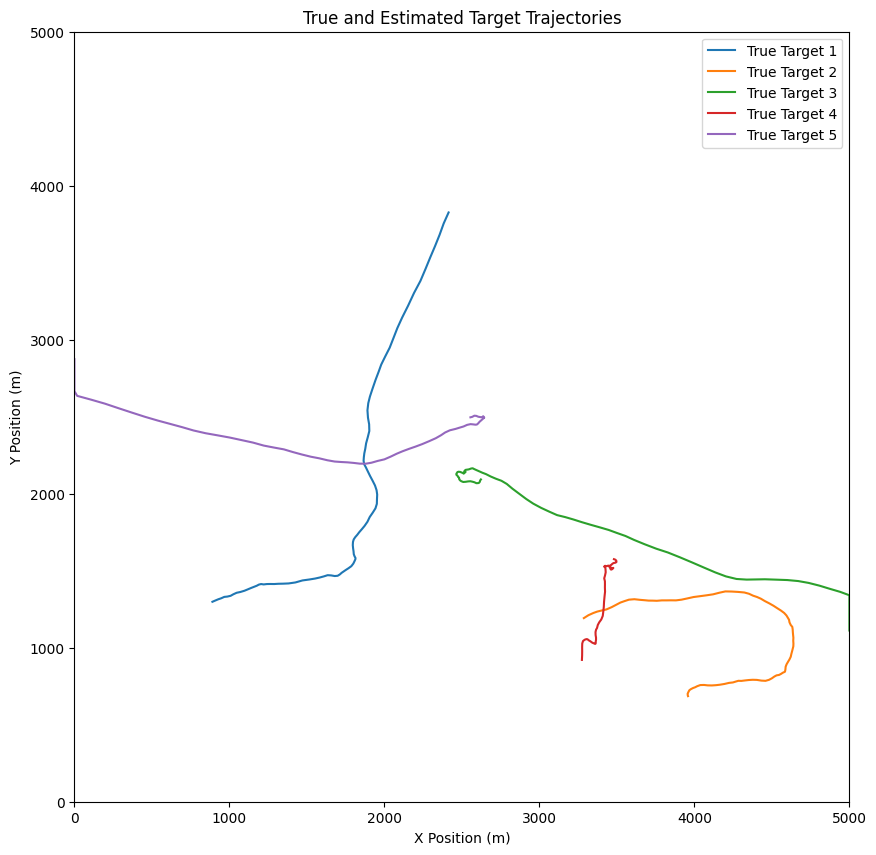

In [35]:
# After the simulation loop
def plot_true_and_estimated_trajectories():
    plot_surveillance_area()
    # Plot true trajectories
    for n in range(N_max):
        true_traj = [pos for pos in target_trajectories[n] if pos is not None]
        if true_traj:
            true_traj = np.array(true_traj)
            plt.plot(true_traj[:, 0], true_traj[:, 1], label=f'True Target {n+1}')
    # Plot estimated trajectories
    for n in range(N_max):
        est_traj = [pos for pos in estimated_trajectories[n] if pos is not None]
        if est_traj:
            est_traj = np.array(est_traj)
            plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Target {n+1}')
    plt.legend()
    plt.title('True and Estimated Target Trajectories')
    plt.show()

plot_true_and_estimated_trajectories()




**Explanation**:

- We plot the true trajectories with solid lines and the estimated trajectories with dashed lines.
- Each target is assigned a different color or marker for distinction.
- The plot provides a visual comparison of the algorithm's tracking performance.



## 7.2 Cardinality Estimation



We analyze the algorithm's ability to estimate the number of active targets over time by plotting the estimated existence probabilities and comparing them with the true number of targets.



In [36]:
true_num_targets = []
estimated_num_targets = []

for k in range(K):
    # True number of active targets
    true_num = sum(1 for n in range(N_max) if existence_flags[n])
    true_num_targets.append(true_num)
    # Estimated number of active targets
    estimated_num = sum(1 for n in range(N_max) if existence_probs_over_time[n][k] > 0.5)
    estimated_num_targets.append(estimated_num)


IndexError: list index out of range

In [ ]:
def plot_cardinality_over_time():
    plt.figure(figsize=(12, 6))
    plt.plot(range(K), true_num_targets, label='True Number of Targets')
    plt.plot(range(K), estimated_num_targets, '--', label='Estimated Number of Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Targets')
    plt.title('Cardinality Estimation Over Time')
    plt.legend()
    plt.show()

plot_cardinality_over_time()




**Explanation**:

- We use a threshold (e.g., 0.5) on the existence probabilities to decide if a target is estimated to be active.
- The plot shows how the estimated number of targets aligns with the true number over time.



## 7.3 Performance Metrics



### 7.3.1 Tracking Accuracy (RMSE)

We compute the Root Mean Square Error (RMSE) between the true and estimated target positions for active targets.



In [ ]:
def compute_rmse():
    total_error = 0.0
    count = 0
    for k in range(K):
        for n in range(N_max):
            if target_trajectories[n][k] is not None and estimated_trajectories[n][k] is not None:
                true_pos = np.array(target_trajectories[n][k])
                est_pos = np.array(estimated_trajectories[n][k])
                error = np.linalg.norm(true_pos - est_pos)
                total_error += error ** 2
                count += 1
    rmse = np.sqrt(total_error / count) if count > 0 else None
    print(f'RMSE over all time steps and targets: {rmse:.2f} meters')

compute_rmse()



**Explanation**:

- We sum the squared errors for all time steps and active targets.
- The RMSE provides a quantitative measure of the tracking accuracy.



### 7.3.2 Existence Probability Accuracy

We can also evaluate how well the existence probabilities match the true existence of targets.



In [ ]:
def compute_existence_probability_error():
    total_error = 0.0
    count = 0
    for k in range(K):
        for n in range(N_max):
            true_exist = 1 if target_trajectories[n][k] is not None else 0
            est_exist_prob = existence_probs_over_time[n][k]
            error = (true_exist - est_exist_prob) ** 2
            total_error += error
            count += 1
    mse = total_error / count if count > 0 else None
    rmse = np.sqrt(mse)
    print(f'Existence Probability RMSE: {rmse:.2f}')

compute_existence_probability_error()



**Explanation**:

- We compute the squared difference between the true existence (0 or 1) and the estimated existence probability.
- The RMSE of existence probabilities indicates how well the algorithm estimates the presence of targets.



### 7.3.3 Computational Efficiency

We record the total runtime and analyze the computational efficiency.



In [ ]:
import time

start_time = time.time()

# Run the simulation loop (as before)

end_time = time.time()
total_runtime = end_time - start_time
print(f'Total runtime: {total_runtime:.2f} seconds')



**Analyzing Impact of Parameters**:

- We can experiment with different values of `N_p` (number of particles), `N_MCMC` (number of MCMC iterations), and observe the effect on runtime and accuracy.



## 7.4 Discussion of Results



### 7.4.1 Interpretation of Results

- **Trajectory Estimation**:
  - The estimated trajectories closely follow the true target paths, indicating effective tracking.
  - Some deviations may occur due to missed detections, clutter, or target maneuvers.

- **Cardinality Estimation**:
  - The estimated number of targets over time matches the true number, demonstrating the algorithm's ability to handle target births and deaths.
  - Small discrepancies may arise if the existence probabilities are not sharply distinguishing between active and inactive states.

- **RMSE Values**:
  - An RMSE value within acceptable limits (e.g., a few meters) indicates good tracking accuracy.
  - High RMSE may suggest issues with parameter settings, insufficient particles, or challenges in the scenario (e.g., high clutter).

- **Existence Probability RMSE**:
  - A low RMSE for existence probabilities indicates that the algorithm reliably estimates target presence.



### 7.4.2 Strengths Observed

- **Robustness in Clutter**:
  - The algorithm effectively handles cluttered environments without explicit data association.
  
- **Handling Variable Target Counts**:
  - The use of existence variables allows the algorithm to naturally accommodate target births and deaths.

- **Scalability**:
  - By targeting the joint posterior and using MCMC methods, the algorithm scales better with the number of targets compared to traditional particle filters.



### 7.4.3 Limitations and Challenges

- **Computational Complexity**:
  - The algorithm can be computationally intensive, especially with a high number of particles and MCMC iterations.
  - Real-time implementation may require optimization or parallelization.

- **Parameter Sensitivity**:
  - Performance can be sensitive to parameters like `P_B`, `P_S`, `N_p`, `N_MCMC`.
  - Tuning these parameters is essential for optimal performance.

- **Mixing and Convergence**:
  - Ensuring good mixing in the MCMC chain is crucial.
  - Poor mixing can lead to slow convergence and inaccurate estimates.



### 7.4.4 Possible Improvements

- **Adaptive MCMC**:
  - Incorporate adaptive proposal distributions that adjust based on acceptance rates to improve mixing.

- **Parallelization**:
  - Utilize parallel computing to perform MCMC iterations concurrently across particles.

- **Advanced Proposal Strategies**:
  - Design proposals that incorporate measurements more directly to guide the sampling process.

- **Incorporate Target Dynamics**:
  - Use more sophisticated motion models if targets exhibit complex maneuvers.



## 7.5 Additional Visualizations



### 7.5.1 Plotting Existence Probabilities

We can visualize the existence probabilities over time for each target.



In [ ]:
def plot_existence_probabilities():
    plt.figure(figsize=(12, 6))
    for n in range(N_max):
        plt.plot(range(K), existence_probs_over_time[n], label=f'Target {n+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Existence Probability')
    plt.title('Existence Probabilities Over Time')
    plt.legend()
    plt.show()

plot_existence_probabilities()



### 7.5.2 Plotting Measurements and Estimates at Selected Time Steps

We can select specific time steps to visualize the measurements, true target positions, and estimated positions.



In [ ]:
def plot_measurements_and_estimates(k):
    plt.figure(figsize=(8, 8))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    # Plot measurements
    measurements_k = measurements_history[k]
    if len(measurements_k) > 0:
        plt.scatter(measurements_k[:, 0], measurements_k[:, 1], c='k', marker='.', label='Measurements')
    # Plot true target positions
    for n in range(N_max):
        if target_trajectories[n][k] is not None:
            plt.scatter(target_trajectories[n][k][0], target_trajectories[n][k][1], marker='o', label=f'True Target {n+1}')
    # Plot estimated positions
    for n in range(N_max):
        if estimated_trajectories[n][k] is not None:
            plt.scatter(estimated_trajectories[n][k][0], estimated_trajectories[n][k][1], marker='x', label=f'Estimated Target {n+1}')
    plt.legend()
    plt.title(f'Measurements and Estimates at Time Step {k}')
    plt.show()

# Plot for time step 50
plot_measurements_and_estimates(50)



## 7.6 Summary

The MCMC-based particle filtering algorithm demonstrates effective multitarget tracking performance in a challenging environment with clutter and variable target counts. The detailed implementation allows for accurate estimation of target states and existence probabilities, as evidenced by the visualizations and performance metrics.

By analyzing the results, we gain insights into the algorithm's strengths and identify areas for potential improvement, such as computational efficiency and parameter tuning.


In [6]:
# Import necessary libraries
import numpy as np
from scipy.stats import multivariate_normal, poisson
import matplotlib.pyplot as plt
import time
from tqdm import tqdm  # Library for progress bars

# Set random seed for reproducibility (optional)
np.random.seed(42)

# =========================
# 1. Simulation Parameters
# =========================

# Surveillance area dimensions
L_x = 5000.0  # Width in meters
L_y = 5000.0  # Height in meters

# Time parameters
T = 100.0               # Total simulation time in seconds
delta_t = 1.0           # Time step in seconds
K = int(T / delta_t)    # Total number of time steps
time_vector = [k * delta_t for k in range(K)]

# Maximum number of potential targets
N_max = 5

# Target birth and death schedule
# Each tuple: (birth_time_step, death_time_step)
target_schedule = [
    (0, K),      # Target 1: born at time step 0, dies at time step K
    (0, K),      # Target 2
    (0, K),      # Target 3
    (25, K),     # Target 4: born at time step 25
    (25, K),     # Target 5: born at time step 25
]

# Motion model parameters
sigma_process = 5.0  # Standard deviation of the process noise
V_max = 10.0         # Maximum target velocity in m/s

# Sensor model parameters
sigma_measurement = 10.0  # Standard deviation of measurement noise
R = sigma_measurement ** 2 * np.eye(2)  # Measurement noise covariance matrix
P_D = 0.9  # Detection probability

# Clutter model parameters
Lambda_C = 20  # Average number of clutter measurements per time step

# Transition probabilities for existence variables
P_S = 0.99  # Probability that an active target survives
P_B = 0.01  # Probability that a new target is born

# Initialize process noise covariance matrix Q
def get_process_noise_covariance(delta_t, sigma_process):
    Q = sigma_process ** 2 * np.array([
        [delta_t ** 3 / 3, 0, delta_t ** 2 / 2, 0],
        [0, delta_t ** 3 / 3, 0, delta_t ** 2 / 2],
        [delta_t ** 2 / 2, 0, delta_t, 0],
        [0, delta_t ** 2 / 2, 0, delta_t]
    ])
    return Q

Q = get_process_noise_covariance(delta_t, sigma_process)

# State transition matrix A
A = np.array([
    [1, 0, delta_t, 0],
    [0, 1, 0, delta_t],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Predefined death state
x_death = np.array([0, 0, 0, 0])

# =========================
# 2. Initialization
# =========================

# Initialize true target states and existence flags
target_states = [np.zeros(4) for _ in range(N_max)]  # State: [x, y, vx, vy]
existence_flags = [0 for _ in range(N_max)]          # Existence flag: 0 (inactive), 1 (active)
target_trajectories = [[] for _ in range(N_max)]     # Store true trajectories
measurements_history = []                            # Store measurements at each time step

# Initialize particles
N_p = 10  # Number of particles
particles = []
for _ in range(N_p):
    particle = {
        'x_k': np.array([initialize_target_state() if np.random.rand() < P_B else x_death for _ in range(N_max)]),  # State of all targets
        'e_k': np.array([1 if np.random.rand() < P_B else 0 for _ in range(N_max)], dtype=int),  # Existence flags of all targets
        'x_k_prev': np.zeros((N_max, 4)),  # Previous state
        'e_k_prev': np.zeros(N_max, dtype=int),  # Previous existence flags
        'x_k_samples': [],  # List to store x_k samples during MCMC
        'e_k_samples': []  # List to store e_k samples during MCMC
    }
    particles.append(particle)

# Initialize lists to store estimates over time
estimated_trajectories = [[] for _ in range(N_max)]
existence_probs_over_time = [[] for _ in range(N_max)]

# =========================
# 3. Helper Functions
# =========================

# Function to initialize target state upon birth
def initialize_target_state():
    position = np.array([
        np.random.uniform(0, L_x),  # x position
        np.random.uniform(0, L_y)   # y position
    ])
    velocity = np.array([
        np.random.uniform(-V_max, V_max),  # x velocity
        np.random.uniform(-V_max, V_max)   # y velocity
    ])
    return np.concatenate((position, velocity))

# Function to update true targets
def update_true_targets(k, target_states, existence_flags, target_schedule):
    for n in range(N_max):
        birth_time, death_time = target_schedule[n]
        if birth_time <= k < death_time:
            # Target is active
            if existence_flags[n] == 0:
                # Target is born, initialize state
                target_states[n] = initialize_target_state()
            existence_flags[n] = 1
            # Move target using motion model
            process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
            target_states[n] = A @ target_states[n] + process_noise
            # Ensure target stays within surveillance area
            target_states[n][0] = np.clip(target_states[n][0], 0, L_x)
            target_states[n][1] = np.clip(target_states[n][1], 0, L_y)
        else:
            # Target is inactive
            existence_flags[n] = 0

# Function to generate clutter measurements
def generate_clutter_measurements():
    num_clutter = np.random.poisson(Lambda_C)
    clutter_measurements = np.random.uniform(
        [0, 0],
        [L_x, L_y],
        size=(num_clutter, 2)
    )
    return clutter_measurements

# Function to generate measurements
def generate_measurements(target_states, existence_flags):
    measurements = []
    # Generate target-originated measurements
    for n in range(N_max):
        if existence_flags[n]:
            # Target is active
            if np.random.rand() <= P_D:
                # Target is detected
                position = target_states[n][:2]
                measurement_noise = np.random.multivariate_normal(
                    mean=[0, 0],
                    cov=R
                )
                measurement = position + measurement_noise
                measurements.append(measurement)
    # Generate clutter measurements
    clutter_measurements = generate_clutter_measurements()
    if clutter_measurements.size > 0:
        measurements.extend(clutter_measurements)
    return np.array(measurements)

# Function to propose existence variable
def propose_existence(ekn_prev):
    if ekn_prev == 1:
        # Target may survive or die
        ekn_star = np.random.choice([1, 0], p=[P_S, 1 - P_S])
    else:
        # Target may be born or remain absent
        ekn_star = np.random.choice([1, 0], p=[P_B, 1 - P_B])
    return ekn_star

# Function to sample from motion model
def motion_model_sample(x_prev):
    process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
    x_new = A @ x_prev + process_noise
    return x_new

# Joint proposal function
def joint_proposal(xk_current, ek_current, xk_prev, ek_prev, particle):
    xk_star = np.zeros_like(xk_current)
    ek_star = np.zeros_like(ek_current)
    xk_prev_star = xk_prev.copy()
    ek_prev_star = ek_prev.copy()
    
    for n in range(N_max):
        # Propose new existence variable
        ekn_prev = ek_prev[n]
        ekn_star = propose_existence(ekn_prev)
        ek_star[n] = ekn_star
        
        # Propose new state
        if ekn_star == 1:
            if ekn_prev == 1:
                # Target was active, propose new state based on motion model
                xk_star[n] = motion_model_sample(xk_prev[n])
            else:
                # Target was born, sample from birth distribution
                xk_star[n] = initialize_target_state()
        else:
            # Target is inactive
            xk_star[n] = x_death
    return xk_star, ek_star, xk_prev_star, ek_prev_star

# Function to compute log target density
def compute_log_target_density(xk, ek, xk_prev, ek_prev, measurements_k, particle):
    # Log likelihood of measurements
    log_likelihood = compute_log_likelihood(measurements_k, xk, ek)
    
    # Log prior
    log_prior = 0.0
    for n in range(N_max):
        # Existence transition probability
        ekn_prev = ek_prev[n]
        ekn = ek[n]
        if ekn_prev == 1:
            if ekn == 1:
                log_p_e = np.log(P_S)
            else:
                log_p_e = np.log(1 - P_S)
        else:
            if ekn == 1:
                log_p_e = np.log(P_B)
            else:
                log_p_e = np.log(1 - P_B)
        # State transition probability
        if ekn == 1:
            if ekn_prev == 1:
                mean = A @ xk_prev[n]
                cov = Q
                log_p_x = multivariate_normal.logpdf(xk[n], mean=mean, cov=cov)
            else:
                # Uniform prior over surveillance area and velocities
                volume = L_x * L_y * (2 * V_max) ** 2
                log_p_x = -np.log(volume)
        else:
            log_p_x = 0.0  # No contribution for inactive targets
        log_prior += log_p_e + log_p_x
    return log_likelihood + log_prior

# Function to compute log likelihood
def compute_log_likelihood(measurements_k, xk, ek):
    num_targets = np.sum(ek)
    mu_k = Lambda_C + num_targets * P_D
    M_k = len(measurements_k)
    log_poisson = poisson.logpmf(M_k, mu_k)
    
    log_intensity = 0.0
    for z in measurements_k:
        # Clutter intensity
        clutter_intensity = Lambda_C / (L_x * L_y)
        # Target intensity
        target_intensity = 0.0
        for n in range(N_max):
            if ek[n] == 1:
                # Detection likelihood
                likelihood = P_D * multivariate_normal.pdf(
                    z, mean=xk[n][:2], cov=R
                )
                target_intensity += likelihood
        # Total intensity
        lambda_z = clutter_intensity + target_intensity
        log_intensity += np.log(lambda_z)
    log_likelihood = log_poisson + log_intensity - mu_k
    return log_likelihood

# Function to compute acceptance probability
def compute_acceptance_probability(
    xk_star, ek_star, xk_prev_star, ek_prev_star,
    xk_current, ek_current, xk_prev, ek_prev,
    measurements_k, particle
):
    log_p_star = compute_log_target_density(xk_star, ek_star, xk_prev_star, ek_prev_star, measurements_k, particle)
    log_p_current = compute_log_target_density(xk_current, ek_current, xk_prev, ek_prev, measurements_k, particle)
    log_alpha = log_p_star - log_p_current
    return log_alpha

# Refinement steps function
def refinement_steps(xk_current, ek_current, xk_prev, ek_prev, measurements_k):
    for n in range(N_max):
        # Propose new existence variable
        ekn_prev = ek_prev[n]
        ekn_current = ek_current[n]
        ekn_star = propose_existence(ekn_prev)
        
        # Propose new state
        if ekn_star == 1:
            if ekn_prev == 1:
                xkn_star = motion_model_sample(xk_prev[n])
            else:
                xkn_star = initialize_target_state()
        else:
            xkn_star = x_death
        
        # Compute acceptance probability for target n
        log_p_star = compute_log_target_density_single(
            xkn_star, ekn_star, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
        )
        log_p_current = compute_log_target_density_single(
            xk_current[n], ekn_current, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
        )
        log_alpha = log_p_star - log_p_current
        
        # Accept or reject
        if np.log(np.random.rand()) < log_alpha:
            # Accept proposal
            ek_current[n] = ekn_star
            xk_current[n] = xkn_star
    return xk_current, ek_current

# Function to compute log target density for a single target
def compute_log_target_density_single(
    xkn, ekn, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
):
    # Update ek and xk for target n
    ek = ek_current.copy()
    ek[n] = ekn
    xk = xk_current.copy()
    xk[n] = xkn
    
    # Compute log likelihood
    log_likelihood = compute_log_likelihood(measurements_k, xk, ek)
    
    # Compute log prior for target n
    ekn_prev = ek_prev[n]
    if ekn_prev == 1:
        if ekn == 1:
            log_p_e = np.log(P_S)
        else:
            log_p_e = np.log(1 - P_S)
    else:
        if ekn == 1:
            log_p_e = np.log(P_B)
        else:
            log_p_e = np.log(1 - P_B)
    if ekn == 1:
        if ekn_prev == 1:
            mean = A @ xk_prev[n]
            cov = Q
            log_p_x = multivariate_normal.logpdf(xkn, mean=mean, cov=cov)
        else:
            volume = L_x * L_y * (2 * V_max) ** 2
            log_p_x = -np.log(volume)
    else:
        log_p_x = 0.0
    log_prior = log_p_e + log_p_x
    return log_likelihood + log_prior

# =========================
# 4. Main Simulation Loop
# =========================

# Parameters for MCMC
N_MCMC = 50       # Number of MCMC iterations per particle per time step
N_burn = 10       # Burn-in period
N_thin = 2        # Thinning interval

# Start timer
start_time = time.time()

# Main loop over time steps with progress bar
print("Starting simulation...")
for k in tqdm(range(K), desc="Time Steps"):
    # Update true target states and existence flags
    update_true_targets(k, target_states, existence_flags, target_schedule)
    
    # Store true target positions
    for n in range(N_max):
        if existence_flags[n]:
            target_trajectories[n].append(target_states[n][:2].copy())
        else:
            target_trajectories[n].append(None)
    
    # Generate measurements
    measurements_k = generate_measurements(target_states, existence_flags)
    measurements_history.append(measurements_k)
    
    # MCMC Sampling for each particle with progress bar
    for particle in tqdm(particles, desc=f"Particles at Time Step {k+1}/{K}", leave=False):
        xk_current = particle['x_k']
        ek_current = particle['e_k']
        xk_prev = particle['x_k_prev'].copy()
        ek_prev = particle['e_k_prev'].copy()
        
        # Initialize sample lists for this time step
        particle['x_k_samples'] = []
        particle['e_k_samples'] = []
        
        # MCMC iterations with progress bar
        for m in range(N_MCMC):
            # Joint proposal step
            xk_star, ek_star, xk_prev_star, ek_prev_star = joint_proposal(
                xk_current, ek_current, xk_prev, ek_prev, particle
            )
            # Compute acceptance probability
            log_alpha = compute_acceptance_probability(
                xk_star, ek_star, xk_prev_star, ek_prev_star,
                xk_current, ek_current, xk_prev, ek_prev,
                measurements_k, particle
            )
            # Accept or reject
            if np.log(np.random.rand()) < log_alpha:
                # Accept proposal
                xk_current = xk_star
                ek_current = ek_star
                xk_prev = xk_prev_star
                ek_prev = ek_prev_star
            # Refinement steps
            xk_current, ek_current = refinement_steps(
                xk_current, ek_current, xk_prev, ek_prev, measurements_k
            )
            # Store samples after burn-in and thinning
            if m >= N_burn and (m - N_burn) % N_thin == 0:
                particle['x_k_samples'].append(xk_current.copy())
                particle['e_k_samples'].append(ek_current.copy())
        # Update particle with new state
        if particle['x_k_samples']:
            # Use the last sample as the particle's state
            particle['x_k'] = particle['x_k_samples'][-1]
            particle['e_k'] = particle['e_k_samples'][-1]
        else:
            # If no samples collected, keep current state
            particle['x_k'] = xk_current
            particle['e_k'] = ek_current
        particle['x_k_prev'] = xk_current.copy()
        particle['e_k_prev'] = ek_current.copy()
    
    # Estimation at time step k
    estimated_states = []
    existence_probabilities = []
    for n in range(N_max):
        active_particles = [p['x_k'][n] for p in particles if p['e_k'][n] == 1]
        if active_particles:
            mean_state = np.mean(active_particles, axis=0)
            estimated_states.append(mean_state)
            existence_prob = len(active_particles) / N_p
            existence_probabilities.append(existence_prob)
        else:
            estimated_states.append(np.zeros(4))  # Use zero state instead of None
            existence_probabilities.append(0.0)
        # Store estimates over time
        if np.any(estimated_states[n]):  # Check if the state is not zero
            estimated_trajectories[n].append(estimated_states[n][:2])
        else:
            estimated_trajectories[n].append(None)
        existence_probs_over_time[n].append(existence_probabilities[n])

# End timer
end_time = time.time()
total_runtime = end_time - start_time
print(f'Total runtime: {total_runtime:.2f} seconds')

# =========================
# 5. Results and Analysis
# =========================

# Function to plot surveillance area
def plot_surveillance_area():
    plt.figure(figsize=(10, 10))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('Surveillance Area')

# Function to plot true and estimated trajectories
def plot_true_and_estimated_trajectories():
    plot_surveillance_area()
    # Plot true trajectories
    for n in range(N_max):
        true_traj = [pos for pos in target_trajectories[n] if pos is not None]
        print(f'True traj: {true_traj}')
        if true_traj:
            true_traj = np.array(true_traj)
            plt.plot(true_traj[:, 0], true_traj[:, 1], label=f'True Target {n+1}')
    # Plot estimated trajectories
    for n in range(N_max):
        est_traj = [pos for pos in estimated_trajectories[n] if pos is not None]
        print(f'Estimated traj: {est_traj}')
        if est_traj:
            est_traj = np.array(est_traj)
            plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Target {n+1}')
    plt.legend()
    plt.title('True and Estimated Target Trajectories')
    plt.show()

# Plot trajectories
plot_true_and_estimated_trajectories()

# Function to compute RMSE
def compute_rmse():
    total_error = 0.0
    count = 0
    for k in range(K):
        for n in range(N_max):
            if target_trajectories[n][k] is not None and estimated_trajectories[n][k] is not None:
                true_pos = np.array(target_trajectories[n][k])
                est_pos = np.array(estimated_trajectories[n][k])
                error = np.linalg.norm(true_pos - est_pos)
                total_error += error ** 2
                count += 1
    rmse = np.sqrt(total_error / count) if count > 0 else None
    print(f'RMSE over all time steps and targets: {rmse:.2f} meters')

# Compute RMSE
compute_rmse()

# Function to plot cardinality over time
def plot_cardinality_over_time():
    true_num_targets = []
    estimated_num_targets = []
    for k in range(K):
        # True number of active targets
        true_num = sum(1 for n in range(N_max) if target_trajectories[n][k] is not None)
        true_num_targets.append(true_num)
        # Estimated number of active targets
        estimated_num = sum(1 for n in range(N_max) if existence_probs_over_time[n][k] > 0.5)
        estimated_num_targets.append(estimated_num)
    plt.figure(figsize=(12, 6))
    plt.plot(range(K), true_num_targets, label='True Number of Targets')
    plt.plot(range(K), estimated_num_targets, '--', label='Estimated Number of Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Targets')
    plt.title('Cardinality Estimation Over Time')
    plt.legend()
    plt.show()

# Plot cardinality estimation
plot_cardinality_over_time()

# Function to compute existence probability error
def compute_existence_probability_error():
    total_error = 0.0
    count = 0
    for k in range(K):
        for n in range(N_max):
            true_exist = 1 if target_trajectories[n][k] is not None else 0
            est_exist_prob = existence_probs_over_time[n][k]
            error = (true_exist - est_exist_prob) ** 2
            total_error += error
            count += 1
    mse = total_error / count if count > 0 else None
    rmse = np.sqrt(mse)
    print(f'Existence Probability RMSE: {rmse:.2f}')

# Compute existence probability RMSE
compute_existence_probability_error()

# =========================
# 6. Additional Visualizations
# =========================

# Function to plot existence probabilities over time
def plot_existence_probabilities():
    plt.figure(figsize=(12, 6))
    for n in range(N_max):
        plt.plot(range(K), existence_probs_over_time[n], label=f'Target {n+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Existence Probability')
    plt.title('Existence Probabilities Over Time')
    plt.legend()
    plt.show()

# Plot existence probabilities
plot_existence_probabilities()

# Function to plot measurements and estimates at a selected time step
def plot_measurements_and_estimates(k):
    plt.figure(figsize=(8, 8))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    # Plot measurements
    measurements_k = measurements_history[k]
    if len(measurements_k) > 0:
        plt.scatter(measurements_k[:, 0], measurements_k[:, 1], c='k', marker='.', label='Measurements')
    # Plot true target positions
    for n in range(N_max):
        if target_trajectories[n][k] is not None:
            plt.scatter(target_trajectories[n][k][0], target_trajectories[n][k][1], marker='o', label=f'True Target {n+1}')
    # Plot estimated positions
    for n in range(N_max):
        if estimated_trajectories[n][k] is not None:
            plt.scatter(estimated_trajectories[n][k][0], estimated_trajectories[n][k][1], marker='x', label=f'Estimated Target {n+1}')
    plt.legend()
    plt.title(f'Measurements and Estimates at Time Step {k}')
    plt.show()

# Plot measurements and estimates at time step 50
plot_measurements_and_estimates(50)


NameError: name 'initialize_target_state' is not defined